# Explanations of functions in `fixed_income_derivatives_E2024`

In [ ]:
import numpy as np
from scipy.stats import norm, ncx2
from scipy.optimize import minimize
from scipy.special import ndtr, gammainc
from scipy.linalg import sqrtm
from numpy.polynomial.hermite import hermfit, hermval, hermder
import copy

import fixed_income_derivatives_E2024 as fid
import matplotlib.pyplot as plt

## General functions

### Function: `zcb_prices_from_spot_rates`

**Formula**

The price of a zero-coupon bond (ZCB), $p(t,T)$, is computed using the formula:

$$
p(t,T) = e^{-R(t,T) \cdot T}
$$

where:
- $ p(t,T) $: Price of the zero-coupon bond maturing at time $ T $,
- $ R(t,T) $: Continuously compounded spot rate for maturity $ T$,
- $ T $: Time to maturity (in years).

If $ T = 0 $, the bond price is set to 1, as it represents an immediate payoff.


In [ ]:
def zcb_prices_from_spot_rates(T, R):
    """
    Compute zero-coupon bond (ZCB) prices from spot rates.

    Parameters:
    T (array-like): An array of maturities in years.
    R (array-like): An array of continuously compounded spot rates corresponding to the maturities.

    Returns:
    np.ndarray: An array of zero-coupon bond prices.

    Notes:
    - If T[i] is effectively zero, the bond price is set to 1 as it represents a bond that matures immediately.
    - The formula for ZCB price is:
        P(T) = exp(-R(T) * T)
      where:
        - P(T) is the price of the ZCB maturing at time T.
        - R(T) is the continuously compounded spot rate for maturity T.
    """
    M = len(T)
    p = np.zeros([M])
    for i in range(0, M):
        if T[i] < 1e-8:
            p[i] = 1
        else:
            p[i] = np.exp(-R[i] * T[i])
    return p

**Example Usage**

In [ ]:
import numpy as np

# Define maturities and spot rates
T = np.array([0.5, 1, 2, 5])
R = np.array([0.02, 0.025, 0.03, 0.035])

# Compute zero-coupon bond prices
prices = zcb_prices_from_spot_rates(T, R)

print("Maturities:", T)
print("Spot Rates:", R)
print("Zero-Coupon Bond Prices:", prices)

Maturities: [0.5 1.  2.  5. ]
Spot Rates: [0.02  0.025 0.03  0.035]
Zero-Coupon Bond Prices: [0.99004983 0.97530991 0.94176453 0.83945702]


### Function: `spot_rates_from_zcb_prices`

**Formula**

The spot rate $ R(t,T) $ is calculated using the formula:

$$ R(t,T) = -\frac{\log(p(t,T))}{T} $$

where:
- $ R(t,T) $: Continuously compounded spot rate for maturity $ T $,
- $ p(t,T) $: Price of the zero-coupon bond maturing at time $ T $,
- $ T $: Time to maturity (in years).

If $ T = 0 $, the spot rate is undefined and set to NaN.

In [ ]:
def spot_rates_from_zcb_prices(T, p):
    """
    Compute spot rates from zero-coupon bond (ZCB) prices.

    Parameters:
    T (array-like): An array of maturities in years.
    p (array-like): An array of zero-coupon bond prices corresponding to the maturities.

    Returns:
    np.ndarray: An array of spot rates (continuously compounded).

    Notes:
    - If T[i] is effectively zero, the spot rate is set to NaN, as it cannot be determined.
    - The formula for the spot rate is:
        R(T) = -log(P(T)) / T
      where:
        - R(T) is the continuously compounded spot rate for maturity T.
        - P(T) is the price of the zero-coupon bond maturing at time T.
    """
    M = len(T)
    r = np.zeros([M])
    for i in range(0, M):
        if T[i] < 1e-12:
            r[i] = np.nan
        else:
            r[i] = -np.log(p[i]) / T[i]
    return r


**Example Usage**

In [ ]:
T = np.array([0.5, 1, 2, 5])
p = np.array([0.99004983, 0.97530991, 0.94176453, 0.83527021])

# Compute spot rates
spot_rates = spot_rates_from_zcb_prices(T, p)

print("Maturities:", T)
print("Zero-Coupon Bond Prices:", p)
print("Spot Rates:", spot_rates)


Maturities: [0.5 1.  2.  5. ]
Zero-Coupon Bond Prices: [0.99004983 0.97530991 0.94176453 0.83527021]
Spot Rates: [0.02000001 0.025      0.03       0.036     ]


### Function: `forward_rates_from_zcb_prices`

**Formula**

Forward rates are calculated based on the zero-coupon bond (ZCB) prices and specified horizon. 

1. For `horizon=0` (approximated instantaneous forward rates):
   $$ f(T) = \frac{\log(p(t,T-\Delta T)) - \log(p(t,T+\Delta T))}{T+\Delta T - (T-\Delta T)} $$

2. For `horizon > 0`:
   $$ f(T) = \frac{\log(p(t,T-\text{horizon})) - \log(p(t,T))}{T - (T-\text{horizon})} = -\frac{\log p(t,T)-\log p(t,S)}{(T-S)}$$

Here:
- $f(t,S,T)$: Forward rate at time $T$.
- $p(t,T)$: Zero-coupon bond price maturing at time $T$.
- $\text{horizon}$: Time difference for the forward rate calculation i.e. the time from now till the start date of loan


In [ ]:
def forward_rates_from_zcb_prices(T, p, horizon=1):
    """
    Compute forward rates from zero-coupon bond (ZCB) prices.

    Parameters:
    T (array-like): An array of maturities in years.
    p (array-like): An array of zero-coupon bond prices corresponding to the maturities.
    horizon (float): The horizon for forward rates computation. 
                     - `horizon=0` computes approximated instantaneous forward rates.
                     - Positive values compute forward rates over the specified horizon.

    Returns:
    np.ndarray: An array of forward rates.

    Notes:
    - For `horizon=0`, the instantaneous forward rate is approximated as:
        $f(T) = \frac{\log(P(T-\Delta T)) - \log(P(T+\Delta T))}{T+\Delta T - (T-\Delta T)}$
    - For `horizon > 0`, the forward rate is calculated as:
        $f(T) = \frac{\log(P(T-\text{horizon})) - \log(P(T))}{T - (T-\text{horizon})}$
    - The first and last elements are treated differently to handle boundary conditions.
    """
    M = len(T)
    f = np.zeros([M])
    if horizon == 0:
        # Approximate instantaneous forward rates
        f[0] = (np.log(p[0]) - np.log(p[1])) / (T[1] - T[0])
        f[-1] = (np.log(p[-2]) - np.log(p[-1])) / (T[-1] - T[-2])
        for m in range(1, M - 1):
            f[m] = (np.log(p[m - 1]) - np.log(p[m + 1])) / (T[m + 1] - T[m - 1])
    elif horizon > 0:
        # Forward rates over the specified horizon
        for m in range(horizon, M):
            f[m] = (np.log(p[m - horizon]) - np.log(p[m])) / (T[m] - T[m - horizon])
    return f


**Example Usage**

In [ ]:
# Define maturities and zero-coupon bond prices
T = np.array([0, 0.5, 1, 2, 5])
p = np.array([1.0, 0.99004983, 0.97530991, 0.94176453, 0.83527021])

# Compute forward rates with different horizons
instantaneous_forward_rates = forward_rates_from_zcb_prices(T, p, horizon=0)
annual_forward_rates = forward_rates_from_zcb_prices(T, p, horizon=1)

print("Maturities:", T)
print("Zero-Coupon Bond Prices:", p)
print("Instantaneous Forward Rates:", instantaneous_forward_rates)
print("1-Year Forward Rates:", annual_forward_rates)

Maturities: [0.  0.5 1.  2.  5. ]
Zero-Coupon Bond Prices: [1.         0.99004983 0.97530991 0.94176453 0.83527021]
Instantaneous Forward Rates: [0.02000001 0.025      0.03333333 0.03875    0.04      ]
1-Year Forward Rates: [0.         0.02000001 0.03       0.035      0.04      ]


### Function: `forward_libor_rates_from_zcb_prices`

**Formula**

Forward LIBOR rates are calculated using the following formula:

$$ f_{\text{LIBOR}}(T) = \frac{p(t,T-\text{horizon}) - p(t,T)}{p(t,T) \cdot (T - (T-\text{horizon}))} =  \frac{p(t, S) - p(t, T)}{p(t, T) \cdot (T - S)} $$

where:
- $f_{\text{LIBOR}}(T)$: Forward LIBOR rate for the period from $T-\text{horizon}$ to $T$,
- $p(t,T)$: Zero-coupon bond price maturing at time $T$,
- $\text{horizon}$: Time difference for the forward rate calculation i.e. the time from now till the start date of loan


In [ ]:
def forward_libor_rates_from_zcb_prices(T, p, horizon=1):
    """
    Compute forward LIBOR rates from zero-coupon bond (ZCB) prices.

    Parameters:
    T (array-like): An array of maturities in years.
    p (array-like): An array of zero-coupon bond prices corresponding to the maturities.
    horizon (float): The horizon over which the forward LIBOR rate is computed.

    Returns:
    np.ndarray: An array of forward LIBOR rates.

    Notes:
    - The forward LIBOR rate is calculated using:
        $$ f_{\text{LIBOR}}(T) = \frac{P(T-\text{horizon}) - P(T)}{P(T) \cdot (T - (T-\text{horizon}))} $$
      where:
        - $f_{\text{LIBOR}}(T)$ is the forward LIBOR rate over the specified horizon.
        - $P(T)$ is the zero-coupon bond price maturing at time $T$.
        - $T - (T-\text{horizon})$ is the time interval for the forward LIBOR rate.
    - This function computes forward LIBOR rates starting from the `horizon` index.
    """
    M = len(T)
    f = np.zeros([M])
    i = horizon
    while i < M:
        f[i] = (p[i - horizon] - p[i]) / (p[i] * (T[i] - T[i - horizon]))
        i += 1
    return f

**Example Usage**

In [ ]:
# Define maturities and zero-coupon bond prices
T = np.array([0, 0.5, 1, 2, 5])
p = np.array([1.0, 0.99004983, 0.97530991, 0.94176453, 0.83527021])

# Compute forward LIBOR rates with a 1-year horizon
libor_rates = forward_libor_rates_from_zcb_prices(T, p, horizon=1)

print("Maturities:", T)
print("Zero-Coupon Bond Prices:", p)
print("1-Year Forward LIBOR Rates:", libor_rates)

Maturities: [0.  0.5 1.  2.  5. ]
Zero-Coupon Bond Prices: [1.         0.99004983 0.97530991 0.94176453 0.83527021]
1-Year Forward LIBOR Rates: [0.         0.02010034 0.03022613 0.03561971 0.04249895]


### Function: `accrual_factor_from_zcb_prices`

This function calculates the accrual factor `S` used in fixed income instruments, particularly swaps and bonds. The accrual factor represents the sum of time intervals weighted by the respective ZCB prices.

**Formula**
$$
S = \sum_{i=1}^{n} (T_{i} - T_{i-1}) \cdot p(t,T_i)
$$
Where:
- $T_i$: Maturities of the fixed payment schedule.
- $p(t,T_i)$: ZCB price corresponding to maturity $T_i$.

In [ ]:
def accrual_factor_from_zcb_prices(t, T_n, T_N, fixed_freq, T, p):
    """
    Calculates the accrual factor from zero-coupon bond (ZCB) prices.

    Parameters:
    t : float
        Current time.
    T_n : float
        Start time of the fixed period.
    T_N : float
        End time of the fixed period.
    fixed_freq : str or float
        Frequency of fixed payments. Acceptable values:
        - "quarterly" (0.25 years)
        - "semiannual" (0.5 years)
        - "annual" (1 year)
        - Or a numeric value representing custom frequency.
    T : array-like
        List of maturities for ZCB prices.
    p : array-like
        Corresponding ZCB prices for maturities in T.

    Returns:
    float
        The accrual factor `S` calculated as a weighted sum of time intervals and ZCB prices.
    """
    T_fix = []
    if isinstance(fixed_freq, str):
        if fixed_freq == "quarterly":
            for i in range(1, int((T_N - T_n) * 4) + 1):
                if T_n + i * 0.25 > t:
                    T_fix.append(T_n + i * 0.25)
        elif fixed_freq == "semiannual":
            for i in range(1, int((T_N - T_n) * 2) + 1):
                if T_n + i * 0.5 > t:
                    T_fix.append(T_n + i * 0.5)
        elif fixed_freq == "annual":
            for i in range(1, int(T_N - T_n) + 1):
                if T_n + i > t:
                    T_fix.append(T_n + i)
    elif isinstance(fixed_freq, (int, float, np.integer, np.floating)):
        for i in range(1, int((T_N - T_n) / fixed_freq) + 1):
            if T_n + i * fixed_freq > t:
                T_fix.append(T_n + i * fixed_freq)
    else:
        raise ValueError("Unsupported frequency type for fixed payments.")

    p_fix = np.array(fid.for_values_in_list_find_value_return_value(T_fix, T, p))
    T_fix = np.array(T_fix)
    S = (T_fix[0] - T_n) * p_fix[0]
    for i in range(1, len(T_fix)):
        S += (T_fix[i] - T_fix[i - 1]) * p_fix[i]
    return S


**Example Usage**

In [ ]:
# Inputs
t = 0
T_n = 0
T_N = 2
fixed_freq = "annual"
T = np.array([0, 1, 2])
p = np.array([1.0, 0.95, 0.90])

# Call function
S = accrual_factor_from_zcb_prices(t, T_n, T_N, fixed_freq, T, p)
print(f"Accrual Factor: {S}")

Accrual Factor: 1.85


### Function: `swap_rate_from_zcb_prices`

This function calculates the par swap rate $R$ and the accrual factor $S$ from zero-coupon bond (ZCB) prices. The par swap rate represents the fixed rate that sets the value of a swap to zero at inception.

**Formula**
- If $t \leq T_n$:
  $$ R = \frac{p(t,T_n) - p(t,T_N)}{S} $$
  
- If $t > T_n$:
  $$ R = \frac{\left((T_n - t) \cdot L + 1\right) \cdot p(t,T_n) - p(t,T_N)}{S} $$

Where:
- $p(t, T_n)$ and $p(t,T_N)$ are the ZCB prices for maturities $T_n$ and $T_N$.
- $S$ is the accrual factor calculated using `accrual_factor_from_zcb_prices`.


In [ ]:
def swap_rate_from_zcb_prices(t, T_n, T_N, fixed_freq, T, p, float_freq=0, L=0):
    """
    Calculates the par swap rate and accrual factor using zero-coupon bond (ZCB) prices.

    Parameters:
    t : float
        Current time.
    T_n : float
        Start time of the swap.
    T_N : float
        End time of the swap.
    fixed_freq : str or float
        Frequency of fixed payments. Acceptable values:
        - "quarterly" (0.25 years)
        - "semiannual" (0.5 years)
        - "annual" (1 year)
        - Or a numeric value representing custom frequency.
    T : array-like
        List of maturities for ZCB prices.
    p : array-like
        Corresponding ZCB prices for maturities in T.
    float_freq : float or str, optional
        Frequency of floating payments, required if `t > T_n`. Default is 0.
    L : float, optional
        Floating rate payment, required if `t > T_n`. Default is 0.

    Returns:
    tuple
        R : float
            Par swap rate.
        S : float
            Accrual factor.
    """
    S = accrual_factor_from_zcb_prices(t, T_n, T_N, fixed_freq, T, p)
    if t <= T_n:
        if T_n < 1e-6:
            p_n = 1
        else:
            Ind_n, output_n = fid.find_value_return_value(T_n, T, p)
            if Ind_n:
                p_n = output_n[0][1]
        Ind_N, output_N = fid.find_value_return_value(T_N, T, p)
        if Ind_N:
            p_N = output_N[0][1]
        R = (p_n - p_N) / S
    elif t > T_n:
        if float_freq == 0:
            print(f"WARNING! Since t is after inception, 'float_freq' must be given as an argument")
            R = np.nan
        else:
            if isinstance(float_freq, str):
                if float_freq == "quarterly":
                    float_freq = 0.25
                elif float_freq == "semiannual":
                    float_freq = 0.5
                elif fixed_freq == "annual":
                    float_freq = 1
            i, I_done = 0, False
            while not I_done and i * float_freq < T_N:
                if i * float_freq >= t:
                    T_n = i * float_freq
                    I_done = True
                i += 1
            if I_done:
                [p_n, p_N] = fid.for_values_in_list_find_value_return_value([T_n, T_N], T, p)
                R = (((T_n - t) * L + 1) * p_n - p_N) / S
            else:
                print(f"WARNING! Not able to compute the par swap rate")
                R = np.nan
    return R, S


**Example Usage**


In [ ]:
# Inputs
t = 0
T_n = 0
T_N = 2
fixed_freq = "semiannual"
T = np.array([0, 1/2, 1, 3/2, 2])
p = np.array([1.0, 0.975, 0.95, 0.93, 0.90])

# Call function
R, S = swap_rate_from_zcb_prices(t, T_n, T_N, fixed_freq, T, p)
print(f"Par Swap Rate: {R}, Accrual Factor: {S}")

Par Swap Rate: 0.05326231691078561, Accrual Factor: 1.8775


### Function: `spot_rate_bump`

This function adjusts (bumps) spot rates for specific maturities and recalculates the corresponding spot rates and zero-coupon bond (ZCB) prices.

**Formula**

If the spot rate $R(t,T_i)$ for maturity $T_i$ is bumped by $\Delta R$ at time `T_bump` with size `size_bump`, the new $R(t,T_i)$ and ZCB price is calculated as:
$$
- R'(T_i) = R(T_i) + \Delta R \\
p'(T_i) = e^{-R'(T_i) \cdot T_i}
$$

In [ ]:
def spot_rate_bump(T_bump, size_bump, T, R_input, p_input):
    """
    Adjusts (bumps) spot rates and recomputes zero-coupon bond (ZCB) prices.

    Parameters:
    T_bump : float, int, list, tuple, or ndarray
        The maturity or maturities for which the spot rate is to be bumped.
    size_bump : float, int, list, tuple, or ndarray
        The size of the bump applied to the spot rate(s).
    T : array-like
        List of maturities corresponding to the spot rates.
    R_input : array-like
        Initial spot rates corresponding to maturities in T.
    p_input : array-like
        Initial ZCB prices corresponding to maturities in T.

    Returns:
    tuple
        R : ndarray
            Updated spot rates after applying the bump.
        p : ndarray
            Updated ZCB prices after applying the bump to the spot rates.
    """
    R, p = R_input.copy(), p_input.copy()
    if isinstance(T_bump, (int, float, np.float64, np.int32, np.int64)):
        I_bump, idx_bump = fid.value_in_list_returns_I_idx(T_bump, T)
        R[idx_bump] = R[idx_bump] + size_bump
        p[idx_bump] = np.exp(-R[idx_bump] * T_bump)
    elif isinstance(T_bump, (tuple, list, np.ndarray)):
        if isinstance(size_bump, (int, float, np.float64)):
            for i in range(len(T_bump)):
                I_bump, idx_bump = fid.value_in_list_returns_I_idx(T_bump[i], T)
                R[idx_bump] = R[idx_bump] + size_bump
                p[idx_bump] = np.exp(-R[idx_bump] * T_bump[i])
        elif isinstance(size_bump, (tuple, list, np.ndarray)):
            for i in range(len(T_bump)):
                I_bump, idx_bump = fid.value_in_list_returns_I_idx(T_bump[i], T)
                R[idx_bump] = R[idx_bump] + size_bump[i]
                p[idx_bump] = np.exp(-R[idx_bump] * T_bump[i])
    return R, p

**Example Usage**

In [ ]:
T_bump = 2 # can also be a list if bump is more than 1 period
size_bump = 0.01 # can also be a list if bump is more than 1 period
T = np.array([1, 2, 3])
R_input = np.array([0.03, 0.035, 0.04])
p_input = np.exp(-R_input * T)

# Call function
R, p = spot_rate_bump(T_bump, size_bump, T, R_input, p_input)
print(f"Updated Spot Rates: {R}")
print(f"Updated ZCB Prices: {p}")

Updated Spot Rates: [0.03  0.045 0.04 ]
Updated ZCB Prices: [0.97044553 0.91393119 0.88692044]


### Function: `macauley_duration`

This function calculates the **Macaulay duration** of a fixed-rate bond, a measure of the weighted average time to receive the bond's cash flows, weighted by the present value of each cash flow.

**Formula**

The Macaulay duration $D$ is given by:
$$
D = \frac{\sum_{i=1}^{N} \frac{C_i \cdot T_i}{(1 + y)^T_i}}{PV}
$$
Where:
- $C_i$: Cash flow at time $T_i$.
- $T_i$: Time to cash flow maturity.
- $y$: Yield to maturity.
- $PV$: Present value of the bond.

In [ ]:
def macauley_duration(pv, T, C, ytm):
    """
    Calculates the Macaulay duration of a fixed-rate bond.

    Parameters:
    pv : float
        Present value (price) of the bond.
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.
    ytm : float
        Yield to maturity (annualized).

    Returns:
    float
        Macaulay duration of the bond.
    """
    D = 0
    N = len(T)
    for i in range(N):
        D += C[i] * T[i] / (1 + ytm) ** T[i]
    D = D / pv
    return D

**Example Usage**

In [ ]:
# Inputs
pv = 950  # Present value of the bond
T = np.array([1, 2, 3])  # Maturities in years
C = np.array([50, 50, 1050])  # Cash flows
ytm = 0.05  # Yield to maturity

# Call function
D = macauley_duration(pv, T, C, ytm)
print(f"Macaulay Duration: {D} years")

Macaulay Duration: 3.0099057166726335 years


### Function: `modified_duration`

This function calculates the **Modified Duration** of a fixed-rate bond, which measures the bond's price sensitivity to changes in interest rates.

**Formula**

The Modified Duration $D_\text{mod}$ is given by:
$$
D_\text{mod} = \frac{D_\text{mac}}{1 + y}
$$
Where:
- $D_\text{mac}$: Macaulay duration.
- $y$: Yield to maturity.

Alternatively:
$$
D_\text{mod} = \frac{\sum_{i=1}^{N} \frac{C_i \cdot T_i}{(1 + y)^T_i}}{PV \cdot (1 + y)}
$$
Where:
- $C_i$: Cash flow at time $T_i$.
- $T_i$: Time to cash flow maturity.
- $y$: Yield to maturity.
- $PV$: Present value of the bond.


In [ ]:
def modified_duration(pv, T, C, ytm):
    """
    Calculates the Modified Duration of a fixed-rate bond.

    Parameters:
    pv : float
        Present value (price) of the bond.
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.
    ytm : float
        Yield to maturity (annualized).

    Returns:
    float
        Modified duration of the bond.
    """
    D = 0
    N = len(T)
    for i in range(N):
        D += C[i] * T[i] / (1 + ytm) ** T[i]
    D = D / (pv * (1 + ytm))
    return D

**Example Usage**

In [ ]:
# Inputs
pv = 950  # Present value of the bond
T = np.array([1, 2, 3])  # Maturities in years
C = np.array([50, 50, 1050])  # Cash flows
ytm = 0.05  # Yield to maturity

# Call function
D_mod = modified_duration(pv, T, C, ytm)
print(f"Modified Duration: {D_mod} years")

Modified Duration: 2.8665768730215557 years


### Function: `convexity`

This function calculates the **Convexity** of a fixed-rate bond, which measures the bond's sensitivity to changes in interest rates, accounting for the curvature of price changes.

**Formula**

The Convexity $C$ is given by:
$$
C = \frac{\sum_{i=1}^{N} \frac{C_i \cdot T_i^2}{(1 + y)^{T_i}}}{PV}
$$
Where:
- $C_i$: Cash flow at time $T_i$.
- $T_i$: Time to cash flow maturity.
- $y$: Yield to maturity.
- $PV$: Present value of the bond.


In [ ]:
def convexity(pv, T, C, ytm):
    """
    Calculates the Convexity of a fixed-rate bond.

    Parameters:
    pv : float
        Present value (price) of the bond.
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.
    ytm : float
        Yield to maturity (annualized).

    Returns:
    float
        Convexity of the bond.
    """
    D = 0
    N = len(T)
    for i in range(N):
        D += C[i] * T[i]**2 / (1 + ytm) ** T[i]
    D = D / pv
    return D

**Example Usage**

In [ ]:
# Inputs
pv = 950  # Present value of the bond
T = np.array([1, 2, 3])  # Maturities in years
C = np.array([50, 50, 1050])  # Cash flows
ytm = 0.05  # Yield to maturity

# Call function
conv = convexity(pv, T, C, ytm)
print(f"Convexity: {conv}")

Convexity: 8.833989736245375


### Function: `price_fixed_rate_bond_from_ytm`

This function calculates the price of a fixed-rate bond using the present value of its cash flows discounted at the yield to maturity (YTM).

**Formula**

The price $P$ of the bond is given by:
$$
P = \sum_{i=1}^{N} \frac{C_i}{(1 + y)^{T_i}}
$$
Where:
- $C_i$: Cash flow at time $T_i$.
- $T_i$: Time to cash flow maturity.
- $y$: Yield to maturity.

In [ ]:
def price_fixed_rate_bond_from_ytm(ytm, T, C):
    """
    Calculates the price of a fixed-rate bond given its yield to maturity (YTM).

    Parameters:
    ytm : float
        Yield to maturity (annualized).
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.

    Returns:
    float
        The price of the fixed-rate bond.
    """
    price = 0
    N = len(T)
    for i in range(N):
        price += C[i] / (1 + ytm) ** T[i]
    return price



**Example Usage**

In [ ]:
ytm = 0.05  # Yield to maturity
T = np.array([1, 2, 3])  # Maturities in years
C = np.array([50, 50, 1050])  # Cash flows

# Call function
price = price_fixed_rate_bond_from_ytm(ytm, T, C)
print(f"Bond Price: {price}")

Bond Price: 999.9999999999999


### Functions: `ytm_obj` and `ytm`

These functions calculate the **yield-to-maturity (YTM)** of a fixed-rate bond by minimizing the sum of squared errors (SSE) between the actual bond price and the bond price derived from a trial YTM.

**Formula** for the Objective Function (`ytm_obj`)

The bond price at a trial YTM is:
$$
PV_\text{trial} = \sum_{i=1}^{N} \frac{C_i}{(1 + y_\text{trial})^{T_i}}
$$
The objective function (SSE) is:
$$
SSE = \text{scaling} \cdot (PV - PV_\text{trial})^2
$$
Where:
- $C_i$: Cash flow at time $T_i$.
- $T_i$: Time to cash flow maturity.
- $y_\text{trial}$: Trial yield to maturity.
- $PV$: Observed bond price.



In [ ]:
def ytm_obj(ytm, pv, T, C, scaling=1):
    """
    Objective function for yield-to-maturity (YTM) calculation.

    Parameters:
    ytm : list or array-like
        Trial yield to maturity (single-element list/array for optimization).
    pv : float
        Present value (price) of the bond.
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.
    scaling : float, optional
        Scaling factor for the sum of squared errors (default is 1).

    Returns:
    float
        Sum of squared errors between actual bond price and the bond price calculated at the given YTM.
    """
    N = len(T)
    pv_new = 0
    for i in range(N):
        pv_new += C[i] / (1 + ytm[0]) ** T[i]
    sse = scaling * (pv - pv_new) ** 2
    return sse

def ytm(pv, T, C, ytm_init=0.05):
    """
    Calculates the yield-to-maturity (YTM) for a fixed-rate bond.

    Parameters:
    pv : float
        Present value (price) of the bond.
    T : array-like
        List of time to cash flow maturities.
    C : array-like
        List of cash flows corresponding to the maturities in T.
    ytm_init : float, optional
        Initial guess for the yield to maturity (default is 0.05).

    Returns:
    float
        The yield to maturity (YTM) of the bond.
    """
    args = (pv, T, C, 1)
    result = minimize(ytm_obj, ytm_init, args=args, options={'disp': False})
    ytm = result.x[0]
    return ytm

In [ ]:
# Inputs
pv = 950  # Present value of the bond
T = np.array([1, 2, 3])  # Maturities in years
C = np.array([50, 50, 1050])  # Cash flows
ytm_init = 0.05  # Initial guess for YTM (optional)

# Call function
calculated_ytm = ytm(pv, T, C)
print(f"Yield to Maturity: {calculated_ytm:.4f}")

Yield to Maturity: 0.0690


## Cox-Ingersoll-Ross (CIR) short rate sigma model

### Function: `zcb_price_cir`

This function calculates the price of a zero-coupon bond (ZCB) under the **Cox-Ingersoll-Ross (CIR) model** for the short rate.

**Formula**

The CIR model expresses the ZCB price $p(T)$ as:
$$
p(T) = A(T) \cdot \exp(-r_0 \cdot B(T))
$$
Where:
- $A(T) = \left(\frac{2\gamma \cdot \exp(0.5T(a + \gamma))}{D(T)}\right)^{\frac{2ab}{\sigma^2}}$
- $B(T) = \frac{2 \cdot (\exp(\gamma T) - 1)}{D(T)}$
- $D(T) = (\gamma + a) \cdot (\exp(\gamma T) - 1) + 2\gamma$
- $\gamma = \sqrt{a^2 + 2\sigma^2}$


In [ ]:
def zcb_price_cir(r0, a, b, sigma, T):
    """
    Calculates the price of a zero-coupon bond (ZCB) under the Cox-Ingersoll-Ross (CIR) short rate model.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        ZCB price(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.float32, np.float64)):
        gamma = np.sqrt(a**2 + 2 * sigma**2)
        D = (gamma + a) * (np.exp(gamma * T) - 1) + 2 * gamma
        A = ((2 * gamma * np.exp(0.5 * T * (a + gamma))) / D)**((2 * a * b) / (sigma**2))
        B = 2 * (np.exp(gamma * T) - 1) / D
        p = A * np.exp(-r0 * B)
    elif isinstance(T, (tuple, list, np.ndarray)):
        M = len(T)
        p = np.zeros([M])
        for i in range(M):
            gamma = np.sqrt(a**2 + 2 * sigma**2)
            D = (gamma + a) * (np.exp(gamma * T[i]) - 1) + 2 * gamma
            A = ((2 * gamma * np.exp(0.5 * T[i] * (a + gamma))) / D)**((2 * a * b) / (sigma**2))
            B = 2 * (np.exp(gamma * T[i]) - 1) / D
            p[i] = A * np.exp(-r0 * B)
    else:
        print(f"T not a recognized type")
        p = False
    return p


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
prices = zcb_price_cir(r0, a, b, sigma, T)
print(f"ZCB Prices: {prices}")

ZCB Prices: [0.9683815  0.93486897 0.90082872]


### Function: `spot_rate_cir`

This function calculates the **spot rate** under the Cox-Ingersoll-Ross (CIR) model for the short rate.

**Formula**

The spot rate $r(T)$ is calculated as:
$$
r(T) = \frac{-\ln(A(T)) + r_0 \cdot B(T)}{T}
$$
Where:
- $A(T) = \left(\frac{2\gamma \cdot \exp(0.5T(a + \gamma))}{D(T)}\right)^{\frac{2ab}{\sigma^2}}$
- $B(T) = \frac{2 \cdot (\exp(\gamma T) - 1)}{D(T)}$
- $D(T) = (\gamma + a) \cdot (\exp(\gamma T) - 1) + 2\gamma$
- $\gamma = \sqrt{a^2 + 2\sigma^2}$

If $T < 10^{-6}$, the spot rate is set to the current short rate:
$$
r(T) = r_0
$$


In [ ]:
def spot_rate_cir(r0, a, b, sigma, T):
    """
    Calculates the spot rate under the Cox-Ingersoll-Ross (CIR) model for the short rate.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        Spot rate(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.float64)):
        if T < 1e-6:
            r = r0
        else:
            gamma = np.sqrt(a**2 + 2 * sigma**2)
            D = (gamma + a) * (np.exp(gamma * T) - 1) + 2 * gamma
            A = ((2 * gamma * np.exp(0.5 * T * (a + gamma))) / D)**((2 * a * b) / (sigma**2))
            B = 2 * (np.exp(gamma * T) - 1) / D
            r = (-np.log(A) + r0 * B) / T
    elif isinstance(T, (tuple, list, np.ndarray)):
        M = len(T)
        r = np.zeros([M])
        for i in range(M):
            if T[i] < 1e-6:
                r[i] = r0
            else:
                gamma = np.sqrt(a**2 + 2 * sigma**2)
                D = (gamma + a) * (np.exp(gamma * T[i]) - 1) + 2 * gamma
                A = ((2 * gamma * np.exp(0.5 * T[i] * (a + gamma))) / D)**((2 * a * b) / (sigma**2))
                B = 2 * (np.exp(gamma * T[i]) - 1) / D
                r[i] = (-np.log(A) + r0 * B) / T[i]
    else:
        print(f"T not a recognized type")
        r = False
    return r


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
spot_rates = spot_rate_cir(r0, a, b, sigma, T)
print(f"Spot Rates: {spot_rates}")

Spot Rates: [0.03212916 0.03367445 0.03481338]


### Function: `forward_rate_cir`

This function calculates the **instantaneous forward rate** under the Cox-Ingersoll-Ross (CIR) model for the short rate.

**Formula**

The forward rate $f(T)$ is given by:
$$
f(T) = c \left(-\frac{N_T}{N} + \frac{D_T}{D}\right) + r_0 \frac{M_T D - M D_T}{D^2}
$$
Where:
- $c = \frac{2ab}{\sigma^2}$
- $N = 2\gamma \exp(0.5T(a + \gamma))$
- $N_T = \gamma(\gamma + a)\exp(0.5T(a + \gamma))$
- $D = (\gamma + a)(\exp(\gamma T) - 1) + 2\gamma$
- $D_T = \gamma(a + \gamma)\exp(\gamma T)$
- $M = 2(\exp(\gamma T) - 1)$
- $M_T = 2\gamma \exp(\gamma T)$
- $\gamma = \sqrt{a^2 + 2\sigma^2}$

If $T < 10^{-6}$, the forward rate is set to the current short rate:
$$
f(T) = r_0
$$


In [ ]:
def forward_rate_cir(r0, a, b, sigma, T):
    """
    Calculates the instantaneous forward rate under the Cox-Ingersoll-Ross (CIR) model for the short rate.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        Instantaneous forward rate(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.float64)):
        if T < 1e-6:
            f = r0
        else:
            c = (2 * a * b) / (sigma**2)
            gamma = np.sqrt(a**2 + 2 * sigma**2)
            N = 2 * gamma * np.exp(0.5 * T * (a + gamma))
            N_T = gamma * (gamma + a) * np.exp(0.5 * T * (a + gamma))
            D = (gamma + a) * (np.exp(gamma * T) - 1) + 2 * gamma
            D_T = gamma * (a + gamma) * np.exp(gamma * T)
            M = 2 * (np.exp(gamma * T) - 1)
            M_T = 2 * gamma * np.exp(gamma * T)
            f = c * (-N_T / N + D_T / D) + r0 * (M_T * D - M * D_T) / D**2
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        f = np.zeros([N])
        for i in range(N):
            if T[i] < 1e-6:
                f[i] = r0
            else:
                c = (2 * a * b) / (sigma**2)
                gamma = np.sqrt(a**2 + 2 * sigma**2)
                N = 2 * gamma * np.exp(0.5 * T[i] * (a + gamma))
                N_T = gamma * (gamma + a) * np.exp(0.5 * T[i] * (a + gamma))
                D = (gamma + a) * (np.exp(gamma * T[i]) - 1) + 2 * gamma
                D_T = gamma * (a + gamma) * np.exp(gamma * T[i])
                M = 2 * (np.exp(gamma * T[i]) - 1)
                M_T = 2 * gamma * np.exp(gamma * T[i])
                f[i] = c * (-N_T / N + D_T / D) + r0 * (M_T * D - M * D_T) / D**2
    else:
        print(f"T not a recognized type")
        f = False
    return f


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
forward_rates = forward_rate_cir(r0, a, b, sigma, T)
print(f"Forward Rates: {forward_rates}")

Forward Rates: [0.03393077 0.03631059 0.03775198]


### Function: `mean_cir`

This function calculates the **mean** of the short rate under the Cox-Ingersoll-Ross (CIR) model at a given time horizon $T$.

**Formula**

For $T = \infty$, the mean is:
$$
\text{mean} = b
$$
For finite $T$, the mean is computed using the non-central chi-squared distribution:
$$
\text{mean} = \frac{\sigma^2 (1 - \exp(-aT))}{4a} \cdot \mathbb{E}[\chi^2]
$$
Where:
- $\chi^2 \sim \text{NonCentralChiSquare}(df, nc)$
- $df = \frac{4ab}{\sigma^2}$ (degrees of freedom)
- $nc = \frac{4a \exp(-aT) r_0}{\sigma^2 (1 - \exp(-aT))}$ (non-centrality parameter)


In [ ]:
def mean_cir(r0, a, b, sigma, T):
    """
    Calculates the mean of the short rate under the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float
        Time horizon.

    Returns:
    float
        Mean of the short rate at time T under the CIR model.
    """
    if T == np.inf:
        mean = b
    else:
        df = (4 * a * b) / sigma**2
        nc = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
        factor = (sigma**2 * (1 - np.exp(-a * T))) / (4 * a)
        mean = factor * ncx2.stats(df, nc, moments='m')
    return mean


In [ ]:
# input
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = 10  # Time horizon

# Call function
mean_rate = mean_cir(r0, a, b, sigma, T)
print(f"Mean Short Rate: {mean_rate}")

Mean Short Rate: 0.03993262053000914


### Function: `stdev_cir`

This function calculates the **standard deviation** of the short rate under the Cox-Ingersoll-Ross (CIR) model at a given time horizon $T$.

**Formula**

For $T = \infty$, the standard deviation is:
$$
\text{stdev} = \sigma \sqrt{\frac{b}{2a}}
$$
For finite $T$, the standard deviation is computed using the variance of the non-central chi-squared distribution:
$$
\text{stdev} = \frac{\sigma^2 (1 - \exp(-aT))}{4a} \cdot \sqrt{\text{Var}[\chi^2]}
$$
Where:
- $\chi^2 \sim \text{NonCentralChiSquare}(df, nc)$
- $df = \frac{4ab}{\sigma^2}$ (degrees of freedom)
- $nc = \frac{4a \exp(-aT) r_0}{\sigma^2 (1 - \exp(-aT))}$ (non-centrality parameter)


In [ ]:
def stdev_cir(r0, a, b, sigma, T):
    """
    Calculates the standard deviation of the short rate under the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float
        Time horizon.

    Returns:
    float
        Standard deviation of the short rate at time T under the CIR model.
    """
    if T == np.inf:
        stdev = sigma * np.sqrt(b / (2 * a))
    else:
        df = (4 * a * b) / sigma**2
        nc = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
        factor = (sigma**2 * (1 - np.exp(-a * T))) / (4 * a)
        stdev = factor * np.sqrt(ncx2.stats(df, nc, moments='v'))
    return stdev


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = 10  # Time horizon

# Call function
stdev_rate = stdev_cir(r0, a, b, sigma, T)
print(f"Standard Deviation of Short Rate: {stdev_rate}")

Standard Deviation of Short Rate: 0.003993210891571996


### Function: `ci_cir`

This function calculates confidence intervals (CIs) for the short rate under the Cox-Ingersoll-Ross (CIR) model for a given time horizon $T$.

**Formula**
- For **lower CI**:
  $$ \text{LB} = \frac{\text{ncx2.ppf}(1 - \text{size\_ci}, df, nc)}{\text{scaling}}, \quad \text{UB} = \infty $$
- For **upper CI**:
  $$ \text{LB} = 0, \quad \text{UB} = \frac{\text{ncx2.ppf}(\text{size\_ci}, df, nc)}{\text{scaling}} $$
- For **two-sided CI**:
  $$ \text{LB} = \frac{\text{ncx2.ppf}\left(\frac{1 - \text{size\_ci}}{2}, df, nc\right)}{\text{scaling}}, \quad
  \text{UB} = \frac{\text{ncx2.ppf}\left(\text{size\_ci} + \frac{1 - \text{size\_ci}}{2}, df, nc\right)}{\text{scaling}} $$

Where:
- $df = \frac{4ab}{\sigma^2}$ (degrees of freedom)
- $nc = \frac{4a \exp(-aT) r_0}{\sigma^2 (1 - \exp(-aT))}$ (non-centrality parameter)
- $\text{scaling} = \frac{4a}{\sigma^2 (1 - \exp(-aT))}$


In [ ]:
def ci_cir(r0, a, b, sigma, T, size_ci, type_ci="two_sided"):
    """
    Calculates confidence intervals for the short rate under the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 : float
        Current short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.
    size_ci : float
        Confidence interval size (e.g., 0.95 for 95% CI).
    type_ci : str, optional
        Type of confidence interval:
        - "lower" for lower bound only.
        - "upper" for upper bound only.
        - "two_sided" for both bounds (default).

    Returns:
    tuple
        lb : float or ndarray
            Lower bound(s) of the confidence interval.
        ub : float or ndarray
            Upper bound(s) of the confidence interval.
    """
    if isinstance(T, (int, float, np.float64)):
        if type_ci == "lower":
            if T < 1e-6:
                lb, ub = r0, r0
            else:
                df = (4 * a * b) / sigma**2
                nc = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
                scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T)))
                lb, ub = ncx2.ppf(1 - size_ci, df, nc) / scaling, np.inf
        elif type_ci == "upper":
            if T < 1e-6:
                lb, ub = r0, r0
            else:
                df = (4 * a * b) / sigma**2
                nc = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
                scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T)))
                lb, ub = 0, ncx2.ppf(size_ci, df, nc) / scaling
        elif type_ci == "two_sided":
            if T < 1e-6:
                lb, ub = r0, r0
            else:
                df = (4 * a * b) / sigma**2
                nc = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
                scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T)))
                lb, ub = (ncx2.ppf((1 - size_ci) / 2, df, nc) / scaling,
                          ncx2.ppf(size_ci + (1 - size_ci) / 2, df, nc) / scaling)
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        lb, ub = np.zeros([N]), np.zeros([N])
        if type_ci == "lower":
            for i in range(N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = r0, r0
                else:
                    df = (4 * a * b) / sigma**2
                    nc = (4 * a * np.exp(-a * T[i]) * r0) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    lb[i], ub[i] = ncx2.ppf(1 - size_ci, df, nc) / scaling, np.inf
        elif type_ci == "upper":
            for i in range(N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = r0, r0
                else:
                    df = (4 * a * b) / sigma**2
                    nc = (4 * a * np.exp(-a * T[i]) * r0) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    lb[i], ub[i] = 0, ncx2.ppf(size_ci, df, nc) / scaling
        elif type_ci == "two_sided":
            for i in range(N):
                if T[i] < 1e-6:
                    lb[i], ub[i] = r0, r0
                else:
                    df = (4 * a * b) / sigma**2
                    nc = (4 * a * np.exp(-a * T[i]) * r0) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    scaling = (4 * a) / (sigma**2 * (1 - np.exp(-a * T[i])))
                    lb[i], ub[i] = (ncx2.ppf((1 - size_ci) / 2, df, nc) / scaling,
                                    ncx2.ppf(size_ci + (1 - size_ci) / 2, df, nc) / scaling)
    else:
        print(f"T not a recognized type")
        lb, ub = False, False
    return lb, ub

**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Current short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity
size_ci = 0.95  # Confidence interval size
type_ci = "two_sided"  # Type of confidence interval

# Call function
lb, ub = ci_cir(r0, a, b, sigma, T, size_ci, type_ci)
print(f"Lower Bounds: {lb}")
print(f"Upper Bounds: {ub}")

Lower Bounds: [0.02852487 0.02983948 0.03082801]
Upper Bounds: [0.03974678 0.04339346 0.04538639]


### Function: `simul_cir`

This function simulates short rates under the **Cox-Ingersoll-Ross (CIR) model** using various methods.

**CIR Model Dynamics:**

The CIR model is given by:
$$
dr_t = a(b - r_t)dt + \sigma \sqrt{r_t}dW_t
$$
Where:
- $r_t$: Short rate at time $t$.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $W_t$: Standard Brownian motion.

**Simulation Methods:**
1. **Exact Method**:
   - Samples directly from the non-central chi-squared distribution.
   - Requires:
     - Degrees of freedom: $df = \frac{4ab}{\sigma^2}$
     - Non-centrality: $nc = \frac{4a\exp(-a\Delta t)r_{t-1}}{\sigma^2(1 - \exp(-a\Delta t))}$
     - Scaling: $\frac{\sigma^2(1 - \exp(-a\Delta t))}{4a}$

2. **Euler-Maruyama Method**:
   $$ r_{t+1} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{r_t} \sqrt{\Delta t} Z_t $$
   Where $Z_t \sim \mathcal{N}(0, 1)$.

3. **Milstein Method**:
   $$ r_{t+1} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{r_t} \sqrt{\Delta t} Z_t +
   \frac{1}{4}\sigma^2 \Delta t (Z_t^2 - 1) $$


In [ ]:
def simul_cir(r0, a, b, sigma, M, T, method="exact"):
    """
    Simulates short rates under the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    M : int
        Number of time steps in the simulation.
    T : float
        Total time horizon of the simulation.
    method : str, optional
        Simulation method:
        - "exact": Uses exact sampling from the non-central chi-squared distribution (default).
        - "euler": Uses the Euler-Maruyama method.
        - "milstein": Uses the Milstein method.

    Returns:
    ndarray
        Simulated short rates at each time step.
    """
    delta = T / M
    r = np.zeros([M + 1])
    r[0] = r0

    if method == "exact":
        delta_sqrt = np.sqrt(delta)
        df = (4 * a * b) / sigma**2
        factor = (sigma**2 * (1 - np.exp(-a * delta))) / (4 * a)
        for m in range(1, M + 1):
            nc = (4 * a * np.exp(-a * delta) * r[m - 1]) / (sigma**2 * (1 - np.exp(-a * delta)))
            r_hat = factor * ncx2.rvs(df, nc)
            r[m] = r_hat if r_hat > 0 else r[m - 1]

    elif method == "euler":
        delta_sqrt = np.sqrt(delta)
        Z = np.random.standard_normal(M)
        for m in range(1, M + 1):
            r_hat = r[m - 1] + a * (b - r[m - 1]) * delta + sigma * np.sqrt(r[m - 1]) * delta_sqrt * Z[m - 1]
            r[m] = r_hat if r_hat > 0 else r[m - 1]

    elif method == "milstein":
        delta_sqrt = np.sqrt(delta)
        Z = np.random.standard_normal(M)
        for m in range(1, M + 1):
            r_hat = (r[m - 1] + a * (b - r[m - 1]) * delta +
                     sigma * np.sqrt(r[m - 1]) * delta_sqrt * Z[m - 1] +
                     0.25 * sigma**2 * delta * (Z[m - 1]**2 - 1))
            r[m] = r_hat if r_hat > 0 else r[m - 1]

    return r

**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
M = 1000  # Number of steps
T = 10  # Time horizon

# Call function
np.random.seed(0)
simulated_rates = simul_cir(r0, a, b, sigma, M, T, method="exact")
print(f"Simulated Short Rates: {simulated_rates}")

Simulated Short Rates: [0.03       0.03022363 0.03069271 ... 0.04085016 0.04091775 0.04108233]


### Functions: `fit_cir_obj` and `fit_cir_no_sigma_obj`

These functions define objective functions to fit the parameters of the Cox-Ingersoll-Ross (CIR) model to observed spot rate data.

**Formula**

The objective function minimizes the sum of squared errors (SSE) between observed spot rates $R^\star(T)$ and model-calculated spot rates $R(T)$:
$$
\text{SSE} = \sum_{m=1}^{M} \text{scaling} \cdot \left(R(T_m) - R^\star(T_m)\right)^2
$$

1. **`fit_cir_obj`**: Fits all four CIR parameters $r_0$, $a$, $b$, and $\sigma$.
2. **`fit_cir_no_sigma_obj`**: Fits $r_0$, $a$, and $b$, with a fixed $\sigma$.


In [ ]:
def fit_cir_obj(param, R_star, T, scaling=1):
    """
    Objective function for fitting the CIR model parameters.

    Parameters:
    param : list or array-like
        CIR model parameters [r0, a, b, sigma]:
        - r0: Initial short rate.
        - a: Mean reversion speed.
        - b: Long-term mean level.
        - sigma: Volatility.
    R_star : array-like
        Observed spot rates.
    T : array-like
        Time to maturities corresponding to the observed spot rates.
    scaling : float, optional
        Scaling factor for the sum of squared errors (default is 1).

    Returns:
    float
        Sum of squared errors between observed and model spot rates.
    """
    r0, a, b, sigma = param
    M = len(T)
    R_fit = spot_rate_cir(r0, a, b, sigma, T)
    y = 0
    for m in range(M):
        y += scaling * (R_fit[m] - R_star[m])**2
    return y

def fit_cir_no_sigma_obj(param, sigma, R_star, T, scaling=1):
    """
    Objective function for fitting the CIR model parameters excluding sigma.

    Parameters:
    param : list or array-like
        CIR model parameters [r0, a, b]:
        - r0: Initial short rate.
        - a: Mean reversion speed.
        - b: Long-term mean level.
    sigma : float
        Volatility (fixed during optimization).
    R_star : array-like
        Observed spot rates.
    T : array-like
        Time to maturities corresponding to the observed spot rates.
    scaling : float, optional
        Scaling factor for the sum of squared errors (default is 1).

    Returns:
    float
        Sum of squared errors between observed and model spot rates.
    """
    r0, a, b = param
    M = len(T)
    R_fit = spot_rate_cir(r0, a, b, sigma, T)
    y = 0
    for m in range(M):
        y += scaling * (R_fit[m] - R_star[m])**2
    return y


**Example Usage**

In [ ]:
# Inputs
R_star = np.array([0.03, 0.032, 0.034])  # Observed spot rates
T = np.array([1, 2, 3])  # Time to maturities
initial_params = [0.03, 0.5, 0.04, 0.02]  # Initial guesses for [r0, a, b, sigma]
scaling = 1

# Minimize the full objective function
result_full = minimize(fit_cir_obj, initial_params, args=(R_star, T, scaling))
print(f"Fitted Parameters (r0, a, b, sigma): {result_full.x}")

# Fixed sigma, fit r0, a, b
sigma_fixed = 0.02
initial_params_no_sigma = [0.03, 0.5, 0.04]
result_no_sigma = minimize(fit_cir_no_sigma_obj, initial_params_no_sigma, args=(sigma_fixed, R_star, T, scaling))
print(f"Fitted Parameters (r0, a, b): {result_no_sigma.x}")

Fitted Parameters (r0, a, b, sigma): [0.02676775 0.50001279 0.04154539 0.01999599]
Fitted Parameters (r0, a, b): [0.02676775 0.50001277 0.0415454 ]


## Vasicek short rate model

### Function: `zcb_price_vasicek`

This function calculates the price of a zero-coupon bond (ZCB) under the **Vasicek model** for the short rate.

**Formula**

The price of a ZCB at time $t=0$ maturing at $T$ is:
$$
p(T) = \exp(A - r_0 B)
$$
Where:
- $B = \frac{1}{a}(1 - \exp(-aT))$
- $A = \frac{(B - T)(ab - 0.5\sigma^2)}{a^2} - \frac{\sigma^2 B^2}{4a}$

**Parameters**
- $r_0$: Initial short rate.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $T$: Time to maturity.


In [ ]:
def zcb_price_vasicek(r0, a, b, sigma, T):
    """
    Calculates the price of a zero-coupon bond (ZCB) under the Vasicek model for the short rate.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        ZCB price(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.int32, np.float64)):
        B = (1 / a) * (1 - np.exp(-a * T))
        A = ((B - T) * (a * b - 0.5 * sigma**2) / a**2) - ((sigma**2 * B**2) / (4 * a))
        p = np.exp(A - r0 * B)
    elif isinstance(T, (tuple, list, np.ndarray)):
        M = len(T)
        p = np.zeros([M])
        for i in range(M):
            B = (1 / a) * (1 - np.exp(-a * T[i]))
            A = ((B - T[i]) * (a * b - 0.5 * sigma**2) / a**2) - ((sigma**2 * B**2) / (4 * a))
            p[i] = np.exp(A - r0 * B)
    else:
        print(f"T not of a recognized type")
        p = False
    return p


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
zcb_prices = zcb_price_vasicek(r0, a, b, sigma, T)
print(f"Zero-Coupon Bond Prices: {zcb_prices}")

Zero-Coupon Bond Prices: [0.96020692 0.90799265 0.85074841]


### Function: `spot_rate_vasicek`

This function calculates the **spot rate** under the Vasicek model for the short rate.

**Formula**

The spot rate $r(T)$ is calculated as:
$$
r(T) =
\begin{cases}
r_0, & \text{if } T < 10^{-6} \\
\frac{-A + r_0 \cdot B}{T}, & \text{otherwise}
\end{cases}
$$
Where:
- $B = \frac{1}{a}(1 - \exp(-aT))$
- $A = \frac{(B - T)(ab - 0.5\sigma^2)}{a^2} - \frac{\sigma^2 B}{4a}$

**Parameters**
- $r_0$: Initial short rate.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $T$: Time to maturity.

In [ ]:
def spot_rate_vasicek(r0, a, b, sigma, T):
    """
    Calculates the spot rate under the Vasicek model for the short rate.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        Spot rate(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        B = (1 / a) * (1 - np.exp(-a * T))
        A = (B - T) * (a * b - 0.5 * sigma**2) / (a**2) - (sigma**2 * B) / (4 * a)
        if T < 1e-6:
            r = r0
        else:
            r = (-A + r0 * B) / T
    elif isinstance(T, (tuple, list, np.ndarray)):
        M = len(T)
        r = np.zeros([M])
        for i in range(M):
            B = (1 / a) * (1 - np.exp(-a * T[i]))
            A = (B - T[i]) * (a * b - 0.5 * sigma**2) / (a**2) - (sigma**2 * B) / (4 * a)
            if T[i] < 1e-6:
                r[i] = r0
            else:
                r[i] = (-A + r0 * B) / T[i]
    else:
        print(f"T not of a recognized type")
        r = False
    return r


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
spot_rates = spot_rate_vasicek(r0, a, b, sigma, T)
print(f"Spot Rates: {spot_rates}")


Spot Rates: [0.04064    0.04822609 0.05382225]


### Function: `forward_rate_vasicek`

This function calculates the **instantaneous forward rate** under the Vasicek model for the short rate.

**Formula**

The forward rate $f(T)$ is given by:
$$
f(T) =
\begin{cases}
r_0, & \text{if } T < 10^{-6} \\
\frac{(1 - B_T)(ab - 0.5\sigma^2)}{a^2} + \frac{\sigma^2 B B_T}{2a} + r_0 B_T, & \text{otherwise}
\end{cases}
$$
Where:
- $B = \frac{1}{a}(1 - \exp(-aT))$
- $B_T = \exp(-aT)$

**Parameters**
- $r_0$: Initial short rate.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $T$: Time to maturity.


In [ ]:
def forward_rate_vasicek(r0, a, b, sigma, T):
    """
    Calculates the instantaneous forward rate under the Vasicek model for the short rate.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    float or ndarray
        Instantaneous forward rate(s) at the given time(s) to maturity.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        B = (1 / a) * (1 - np.exp(-a * T))
        B_T = np.exp(-a * T)
        if T < 1e-6:
            f = r0
        else:
            f = ((1 - B_T) * (a * b - 0.5 * sigma**2) / (a**2) +
                 (sigma**2 * B * B_T) / (2 * a) + r0 * B_T)
    elif isinstance(T, (tuple, list, np.ndarray)):
        M = len(T)
        f = np.zeros([M])
        for i in range(M):
            B = (1 / a) * (1 - np.exp(-a * T[i]))
            B_T = np.exp(-a * T[i])
            if T[i] < 1e-6:
                f[i] = r0
            else:
                f[i] = ((1 - B_T) * (a * b - 0.5 * sigma**2) / (a**2) +
                        (sigma**2 * B * B_T) / (2 * a) + r0 * B_T)
    else:
        print(f"T not of a recognized type")
        f = False
    return f


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
forward_rates = forward_rate_vasicek(r0, a, b, sigma, T)
print(f"Forward Rates: {forward_rates}")

Forward Rates: [0.04954961 0.06128637 0.06836067]


### Function: `mean_vasicek`

This function calculates the **mean** of the short rate under the Vasicek model at a given time horizon $T$.

**Formula**

The mean of the short rate is given by:
$$
\text{mean} =
\begin{cases}
\frac{b}{a}, & \text{if } T = \infty \\
r_0 \exp(-aT) + \frac{b}{a}(1 - \exp(-aT)), & \text{if } T < \infty
\end{cases}
$$

**Parameters**
- $r_0$: Initial short rate.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $T$: Time horizon.


In [ ]:
def mean_vasicek(r0, a, b, sigma, T):
    """
    Calculates the mean of the short rate under the Vasicek model.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float
        Time horizon.

    Returns:
    float
        Mean of the short rate at time T under the Vasicek model.
    """
    if T == np.inf:
        mean = b / a
    else:
        mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
    return mean


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = 10  # Time horizon

# Call function
mean_rate = mean_vasicek(r0, a, b, sigma, T)
print(f"Mean Short Rate: {mean_rate}")

Mean Short Rate: 0.07966310265004573


### Function: `stdev_vasicek`

This function calculates the **standard deviation** of the short rate under the Vasicek model at a given time horizon $T$.

**Formula**
The standard deviation of the short rate is given by:
$$
\text{std} =
\begin{cases}
\sqrt{\frac{\sigma^2}{2a}}, & \text{if } T = \infty \\
\sqrt{\frac{\sigma^2}{2a} (1 - \exp(-2aT))}, & \text{if } T < \infty
\end{cases}
$$

**Parameters**
- $r_0$: Initial short rate.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $T$: Time horizon.

In [ ]:
def stdev_vasicek(r0, a, b, sigma, T):
    """
    Calculates the standard deviation of the short rate under the Vasicek model.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float
        Time horizon.

    Returns:
    float
        Standard deviation of the short rate at time T under the Vasicek model.
    """
    if T == np.inf:
        std = np.sqrt(sigma**2 / (2 * a))
    else:
        std = np.sqrt(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T)))
    return std

**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = 10  # Time horizon

# Call function
std_dev = stdev_vasicek(r0, a, b, sigma, T)
print(f"Standard Deviation of Short Rate: {std_dev}")

Standard Deviation of Short Rate: 0.019999545995549376


### Function: `ci_vasicek`

This function calculates confidence intervals (CIs) for the short rate under the Vasicek model for a given time horizon $T$.

**Formula**

The confidence intervals are calculated based on the mean and standard deviation of the short rate:
- **Mean**:
  $$ \text{mean} =
  \begin{cases}
  \frac{b}{a}, & \text{if } T = \infty \\
  r_0 \exp(-aT) + \frac{b}{a}(1 - \exp(-aT)), & \text{if } T < \infty
  \end{cases} $$
- **Standard Deviation**:
  $$ \text{std} =
  \begin{cases}
  \sqrt{\frac{\sigma^2}{2a}}, & \text{if } T = \infty \\
  \sqrt{\frac{\sigma^2}{2a} (1 - \exp(-2aT))}, & \text{if } T < \infty
  \end{cases} $$

**Types of Confidence Intervals**
- **Lower Bound**:
  $$ \text{LB} = \text{mean} - z \cdot \text{std}, \quad \text{UB} = \infty $$
- **Upper Bound**:
  $$ \text{LB} = -\infty, \quad \text{UB} = \text{mean} + z \cdot \text{std} $$
- **Two-Sided**:
  $$ \text{LB} = \text{mean} - z \cdot \text{std}, \quad \text{UB} = \text{mean} + z \cdot \text{std} $$

In [ ]:
def ci_vasicek(r0, a, b, sigma, T, size_ci, type_ci="two_sided"):
    """
    Calculates confidence intervals for the short rate under the Vasicek model.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.
    size_ci : float
        Confidence interval size (e.g., 0.95 for 95% CI).
    type_ci : str, optional
        Type of confidence interval:
        - "lower": Calculates only the lower bound.
        - "upper": Calculates only the upper bound.
        - "two_sided": Calculates both bounds (default).

    Returns:
    tuple
        lb : float or ndarray
            Lower bound(s) of the confidence interval.
        ub : float or ndarray
            Upper bound(s) of the confidence interval.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
        if type_ci == "lower":
            if T < 1e-6:
                lb, ub = r0, r0
            elif T == np.inf:
                mean = b / a
                std = np.sqrt(sigma**2 / (2 * a))
                lb, ub = mean - z * std, np.inf
            else:
                mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
                std = np.sqrt(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T)))
                lb, ub = mean - z * std, np.inf
        elif type_ci == "upper":
            if T < 1e-6:
                lb, ub = r0, r0
            elif T == np.inf:
                mean = b / a
                std = np.sqrt(sigma**2 / (2 * a))
                lb, ub = -np.inf, mean + z * std
            else:
                mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
                std = np.sqrt(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T)))
                lb, ub = -np.inf, mean + z * std
        elif type_ci == "two_sided":
            if T < 1e-6:
                lb, ub = r0, r0
            elif T == np.inf:
                mean = b / a
                std = np.sqrt(sigma**2 / (2 * a))
                lb, ub = mean - z * std, mean + z * std
            else:
                mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
                std = np.sqrt(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T)))
                lb, ub = mean - z * std, mean + z * std
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        lb, ub = np.zeros([N]), np.zeros([N])
        z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
        for i in range(N):
            if T[i] < 1e-6:
                lb[i], ub[i] = r0, r0
            else:
                mean = r0 * np.exp(-a * T[i]) + (b / a) * (1 - np.exp(-a * T[i]))
                std = np.sqrt(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * T[i])))
                if type_ci == "lower":
                    lb[i], ub[i] = mean - z * std, np.inf
                elif type_ci == "upper":
                    lb[i], ub[i] = -np.inf, mean + z * std
                elif type_ci == "two_sided":
                    lb[i], ub[i] = mean - z * std, mean + z * std
    else:
        print(f"T is not of recognized type")
        lb, ub = False, False
    return lb, ub

**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean level
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity
size_ci = 0.95  # Confidence interval size
type_ci = "two_sided"  # Type of confidence interval

# Call function
lb, ub = ci_vasicek(r0, a, b, sigma, T, size_ci, type_ci)
print(f"Lower Bounds: {lb}")
print(f"Upper Bounds: {ub}")

Lower Bounds: [0.01850768 0.02515566 0.03063248]
Upper Bounds: [0.08083925 0.0980564  0.10705451]


### Function: `simul_vasicek`

This function simulates short rates under the **Vasicek model** using different methods.

**Vasicek Model Dynamics**
The Vasicek model is given by:
$$
dr_t = a(b - r_t)dt + \sigma dW_t
$$
Where:
- $r_t$: Short rate at time $t$.
- $a$: Mean reversion speed.
- $b$: Long-term mean level.
- $\sigma$: Volatility of the short rate.
- $W_t$: Standard Brownian motion.

**Simulation Methods**
1. **Exact Method**:
   $$ r_{t+\Delta t} = r_t \exp(-a\Delta t) + \frac{b}{a}(1 - \exp(-a\Delta t)) +
   \sigma \sqrt{\frac{1 - \exp(-2a\Delta t)}{2a}} Z_t $$
   Where $Z_t \sim \mathcal{N}(0, 1)$.

2. **Euler and Milstein Methods**:
   $$ r_{t+\Delta t} = r_t + (b - a r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t $$
   Where $Z_t \sim \mathcal{N}(0, 1)$.


In [ ]:
def simul_vasicek(r0, a, b, sigma, M, T, method="exact", seed=None):
    """
    Simulates short rates under the Vasicek model.

    Parameters:
    r0 : float
        Initial short rate.
    a : float
        Mean reversion speed of the short rate.
    b : float
        Long-term mean level of the short rate.
    sigma : float
        Volatility of the short rate.
    M : int
        Number of time steps in the simulation.
    T : float
        Total time horizon of the simulation.
    method : str, optional
        Simulation method:
        - "exact": Uses exact discretization of the Vasicek model (default).
        - "euler": Uses the Euler-Maruyama method.
        - "milstein": Uses the Milstein method.
    seed : int, optional
        Seed for random number generation (default is None).

    Returns:
    ndarray
        Simulated short rates at each time step.
    """
    if seed is not None:
        np.random.seed(seed)
    delta = T / M
    r = np.zeros([M + 1])
    r[0] = r0
    Z = np.random.standard_normal(M)

    if method == "exact":
        for m in range(1, M + 1):
            r[m] = (r[m - 1] * np.exp(-a * delta) +
                    (b / a) * (1 - np.exp(-a * delta)) +
                    sigma * np.sqrt((1 - np.exp(-2 * a * delta)) / (2 * a)) * Z[m - 1])
    elif method == "euler" or method == "milstein":
        delta_sqrt = np.sqrt(delta)
        for m in range(1, M + 1):
            r[m] = (r[m - 1] +
                    (b - a * r[m - 1]) * delta +
                    sigma * delta_sqrt * Z[m - 1])
    return r


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.04   # Long-term mean rate
sigma = 0.02  # Volatility
M = 1000  # Number of time steps
T = 10  # Time horizon
method = "exact"  # Simulation method
seed = 42  # Random seed for reproducibility

# Call function
np.random.seed(0)
simulated_rates = simul_vasicek(r0, a, b, sigma, M, T, method, seed)
print(f"Simulated Short Rates: {simulated_rates}")

Simulated Short Rates: [0.03       0.03124033 0.03120768 ... 0.10483773 0.10357434 0.10459907]


### Function: `euro_option_price_vasicek`

This function calculates the price of a **European call or put option** on a zero-coupon bond under the Vasicek model.

**Formula**

The option price is given by:
- **Call Option**:
  $$ \text{price} = p(T_2) \cdot N(d_1) - p(T_1) \cdot K \cdot N(d_2) $$
- **Put Option**:
  $$ \text{price} = p(T_1) \cdot K \cdot N(-d_2) - p(T_2) \cdot N(-d_1) $$

Where:
- $d_1 = \frac{\ln\left(\frac{p(T_2)}{p(T_1) \cdot K}\right)}{\sigma_p} + 0.5 \cdot \sigma_p$
- $d_2 = d_1 - \sigma_p$
- $\sigma_p = \frac{\sigma}{a} \cdot (1 - \exp(-a(T_2 - T_1))) \cdot \sqrt{\frac{1 - \exp(-2aT_1)}{2a}}$
- $p(T_1)$: Price of the zero-coupon bond maturing at $T_1$.
- $p(T_2)$: Price of the zero-coupon bond maturing at $T_2$.
- $K$: Strike price.
- $N(\cdot)$: Cumulative standard normal distribution.


In [ ]:
def euro_option_price_vasicek(K, T1, T2, p_T1, p_T2, a, sigma, type="call"):
    """
    Calculates the price of a European call or put option on a zero-coupon bond
    under the Vasicek model.

    Parameters:
    K : float
        Strike price of the option.
    T1 : float
        Option maturity (time at which the option is exercised).
    T2 : float
        Bond maturity (time at which the underlying bond matures).
    p_T1 : float
        Price of the zero-coupon bond maturing at T1.
    p_T2 : float
        Price of the zero-coupon bond maturing at T2.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    type : str, optional
        Type of option: "call" (default) or "put".

    Returns:
    float
        Price of the European option.
    """
    sigma_p = (sigma / a) * (1 - np.exp(-a * (T2 - T1))) * np.sqrt((1 - np.exp(-2 * a * T1)) / (2 * a))
    d1 = (np.log(p_T2 / (p_T1 * K))) / sigma_p + 0.5 * sigma_p
    d2 = d1 - sigma_p
    if type == "call":
        price = p_T2 * norm.cdf(d1) - p_T1 * K * norm.cdf(d2)
    elif type == "put":
        price = p_T1 * K * norm.cdf(-d2) - p_T2 * norm.cdf(-d1)
    return price


**Example Usage**

In [ ]:
# Inputs
K = 0.95  # Strike price
T1 = 1    # Option maturity
T2 = 2    # Bond maturity
p_T1 = 0.98  # Price of ZCB maturing at T1
p_T2 = 0.94  # Price of ZCB maturing at T2
a = 0.5    # Mean reversion speed
sigma = 0.02  # Volatility
type_option = "call"  # Option type

# Call function
price = euro_option_price_vasicek(K, T1, T2, p_T1, p_T2, a, sigma, type=type_option)
print(f"European Option Price: {price}")

European Option Price: 0.010486090516255708


### Function: `caplet_prices_vasicek`

This function calculates the prices of caplets under the **Vasicek model**.

**Formula**

The price of a caplet for maturity $T_i$ is:
$$
\text{Caplet Price} = \left(1 + (T_i - T_{i-1}) \cdot \text{strike}\right) \cdot \text{Put Option Price}
$$
Where the **put option price** is calculated using:
$$
\text{euro\_option\_price\_vasicek}(K, T_{i-1}, T_i, p(T_{i-1}), p(T_i), a, \sigma, \text{"put"})
$$

**Parameters**
- $\sigma$: Volatility of the short rate.
- $\text{strike}$: Strike rate for the caplet.
- $a$: Mean reversion speed.
- $T$: Array of times representing caplet maturities.
- $p$: Array of zero-coupon bond prices corresponding to maturities $T$.




In [ ]:
def caplet_prices_vasicek(sigma, strike, a, T, p):
    """
    Calculates the prices of caplets under the Vasicek model.

    Parameters:
    sigma : float
        Volatility of the short rate.
    strike : float
        Strike rate of the caplet.
    a : float
        Mean reversion speed of the short rate.
    T : array-like
        Array of times representing the caplet maturities.
    p : array-like
        Array of zero-coupon bond prices corresponding to maturities in T.

    Returns:
    ndarray
        Array of caplet prices corresponding to the maturities in T.
    """
    price_caplet = np.zeros(len(T))
    for i in range(2, len(T)):
        forward_rate_factor = 1 / (1 + (T[i] - T[i-1]) * strike)
        caplet_price = euro_option_price_vasicek(
            forward_rate_factor, T[i-1], T[i], p[i-1], p[i], a, sigma, type="put"
        )
        price_caplet[i] = (1 + (T[i] - T[i-1]) * strike) * caplet_price
    return price_caplet

**Example Usage**

In [ ]:
# Inputs
sigma = 0.02  # Volatility
strike = 0.03  # Strike rate
a = 0.5    # Mean reversion speed
T = np.array([0, 1, 2, 3])  # Maturities
p = np.array([1.0, 0.98, 0.95, 0.92])  # ZCB prices for maturities in T

# Call function
caplet_prices = caplet_prices_vasicek(sigma, strike, a, T, p)
print(f"Caplet Prices: {caplet_prices}")

Caplet Prices: [0.         0.         0.00567504 0.0068221 ]


### Functions: `fit_vasicek_obj` and `fit_vasicek_no_sigma_obj`

These functions define objective functions to fit the parameters of the Vasicek model to observed spot rate data.

**Formula**

The objective function minimizes the sum of squared errors (SSE) between observed spot rates $R^\star(T)$ and model-calculated spot rates $R(T)$:
$$
\text{SSE} = \sum_{m=1}^{M} \text{scaling} \cdot \left(R(T_m) - R^\star(T_m)\right)^2
$$

1. **`fit_vasicek_obj`**: Fits all four Vasicek parameters $r_0$, $a$, $b$, and $\sigma$.
2. **`fit_vasicek_no_sigma_obj`**: Fits $r_0$, $a$, and $b$, with a fixed $\sigma$.


In [ ]:
def fit_vasicek_obj(param, R_star, T, scaling=1):
    """
    Objective function for fitting the Vasicek model parameters.

    Parameters:
    param : list or array-like
        Vasicek model parameters [r0, a, b, sigma]:
        - r0: Initial short rate.
        - a: Mean reversion speed.
        - b: Long-term mean level.
        - sigma: Volatility.
    R_star : array-like
        Observed spot rates.
    T : array-like
        Time to maturities corresponding to the observed spot rates.
    scaling : float, optional
        Scaling factor for the sum of squared errors (default is 1).

    Returns:
    float
        Sum of squared errors between observed and model spot rates.
    """
    r0, a, b, sigma = param
    M = len(T)
    R_fit = spot_rate_vasicek(r0, a, b, sigma, T)
    y = 0
    for m in range(M):
        y += scaling * (R_fit[m] - R_star[m])**2
    return y

def fit_vasicek_no_sigma_obj(param, sigma, R_star, T, scaling=1):
    """
    Objective function for fitting the Vasicek model parameters excluding sigma.

    Parameters:
    param : list or array-like
        Vasicek model parameters [r0, a, b]:
        - r0: Initial short rate.
        - a: Mean reversion speed.
        - b: Long-term mean level.
    sigma : float
        Volatility (fixed during optimization).
    R_star : array-like
        Observed spot rates.
    T : array-like
        Time to maturities corresponding to the observed spot rates.
    scaling : float, optional
        Scaling factor for the sum of squared errors (default is 1).

    Returns:
    float
        Sum of squared errors between observed and model spot rates.
    """
    r0, a, b = param
    M = len(T)
    R_fit = spot_rate_vasicek(r0, a, b, sigma, T)
    y = 0
    for m in range(M):
        y += scaling * (R_fit[m] - R_star[m])**2
    return y


**Example Usage**

In [ ]:
# Inputs
R_star = np.array([0.03, 0.032, 0.034])  # Observed spot rates
T = np.array([1, 2, 3])  # Time to maturities
initial_params = [0.03, 0.5, 0.04, 0.02]  # Initial guesses for [r0, a, b, sigma]
scaling = 1

# Minimize the full objective function
result_full = minimize(fit_vasicek_obj, initial_params, args=(R_star, T, scaling))
print(f"Fitted Parameters (r0, a, b, sigma): {result_full.x}")

# Fixed sigma, fit r0, a, b
sigma_fixed = 0.02
initial_params_no_sigma = [0.03, 0.5, 0.04]
result_no_sigma = minimize(fit_vasicek_no_sigma_obj, initial_params_no_sigma, args=(sigma_fixed, R_star, T, scaling))
print(f"Fitted Parameters (r0, a, b): {result_no_sigma.x}")

Fitted Parameters (r0, a, b, sigma): [0.02655387 0.50082655 0.02122002 0.02068901]
Fitted Parameters (r0, a, b): [0.02656765 0.50082797 0.02119232]


## Ho-Lee short rate model

### Function: `theta_ho_lee`

This function calculates the **theta parameter (drift term)** in the Ho-Lee model for different approaches.

**Formula**
1. **Default Method**:
   $$ \theta(t) = f_T + \sigma^2 t $$
   Where:
   - $f_T$: Forward rate at time $t$.
   - $\sigma$: Volatility of the model.

2. **Nelson-Siegel Method**:
   $$ \theta(t) = -a_0 b_0 \exp(-b_0 t) + \sigma^2 t +
   \sum_{k=1}^{K} \left(a_k k t^{k-1} \exp(-b_k t) - a_k b_k t^k \exp(-b_k t)\right) $$

**Parameters**
- `t`: Time(s) at which theta is calculated.
- `param`: Model parameters, dependent on the method:
  - For "default": $\sigma$ (volatility).
  - For "nelson_siegel": $(f_\infty, a, b, \sigma)$.
- `method`: Method to calculate $\theta(t)$ ("default" or "nelson_siegel").
- `f_T`: Forward rate(s) at time $t$ (used with `method="default"`).


In [ ]:
def theta_ho_lee(t, param, method="default", f_T=None):
    """
    Calculates the theta parameter (drift term) of the Ho-Lee model.

    Parameters:
    t : float, int, list, tuple, or ndarray
        Time(s) at which theta is calculated.
    param : float, list, or tuple
        Model parameters:
        - For `method="default"`: param = sigma (volatility of the model).
        - For `method="nelson_siegel"`: param = (f_inf, a, b, sigma), where:
            - f_inf: Long-term forward rate.
            - a, b: Nelson-Siegel parameters.
            - sigma: Volatility.
    method : str, optional
        Calculation method:
        - "default" (default): Uses the Ho-Lee drift term with sigma and f_T.
        - "nelson_siegel": Uses the Nelson-Siegel approach with additional parameters.
    f_T : float or ndarray, optional
        Forward rate(s) at time(s) t (used with `method="default"`).

    Returns:
    float or ndarray
        Theta parameter(s) at the given time(s).
    """
    if method == "default":
        sigma = param
        if isinstance(t, (int, float, np.int32, np.int64, np.float64)):
            theta = f_T + sigma**2 * t
        elif isinstance(t, (tuple, list, np.ndarray)):
            N = len(t)
            theta = np.zeros(N)
            for n in range(N):
                theta[n] = f_T[n] + sigma**2 * t[n]
    elif method == "nelson_siegel":
        f_inf, a, b, sigma = param
        if isinstance(t, (int, float, np.int32, np.int64, np.float64)):
            K = len(a)
            theta = -a[0] * b[0] * np.exp(-b[0] * t) + sigma**2 * t
            for k in range(1, K):
                theta += (a[k] * k * t**(k - 1) * np.exp(-b[k] * t) -
                          a[k] * b[k] * t**k * np.exp(-b[k] * t))
        elif isinstance(t, (tuple, list, np.ndarray)):
            K = len(a)
            M = len(t)
            theta = np.zeros(M)
            for m in range(M):
                theta[m] = -a[0] * b[0] * np.exp(-b[0] * t[m]) + sigma**2 * t[m]
                for k in range(1, K):
                    theta[m] += (a[k] * k * t[m]**(k - 1) * np.exp(-b[k] * t[m]) -
                                 a[k] * b[k] * t[m]**k * np.exp(-b[k] * t[m]))
    return theta


**Example Usage**

In [ ]:
# Default method inputs
t = np.array([1, 2, 3])
sigma = 0.02
f_T = np.array([0.03, 0.032, 0.034])

# Nelson-Siegel method inputs
param_ns = (0.05, [0.03, 0.02], [0.1, 0.2], 0.02)

# Call function for default method
theta_default = theta_ho_lee(t, sigma, method="default", f_T=f_T)
print(f"Theta (Default Method): {theta_default}")

# Call function for Nelson-Siegel method
theta_ns = theta_ho_lee(t, param_ns, method="nelson_siegel")
print(f"Theta (Nelson-Siegel Method): {theta_ns}")

Theta (Default Method): [0.0304 0.0328 0.0352]
Theta (Nelson-Siegel Method): [0.01078518 0.00638765 0.00336804]


### Function: `zcb_price_ho_lee`

This function calculates the **price of a zero-coupon bond (ZCB)** under the Ho-Lee model.

**Formula**

The ZCB price at time $t$ for maturity $T$ is given by:
$$
p(t, T) = \frac{p(T)}{p(t)} \cdot \exp\left((T - t)(f^\star - r) - \frac{\sigma^2}{2} t (T - t)^2\right)
$$
Where:
- $p(t)$: ZCB price at time $t$.
- $p(T)$: ZCB price at time $T$.
- $r$: Short rate at time $t$.
- $\sigma$: Volatility of the short rate.
- $f^\star$: Instantaneous forward rate.

**Parameters**
- `t`: Current time.
- `T`: Time(s) to bond maturity.
- `r`: Short rate at time $t$.
- $\sigma$: Volatility of the short rate.
- $T^\star$: Known time points for ZCB prices.
- $p^\star$: Known ZCB prices at $T^\star$.
- $f^\star$: Instantaneous forward rate.

In [ ]:
def zcb_price_ho_lee(t, T, r, sigma, T_star, p_star, f_star):
    """
    Calculates the price of a zero-coupon bond (ZCB) under the Ho-Lee model.

    Parameters:
    t : float
        Current time.
    T : float, int, list, tuple, or ndarray
        Time(s) to bond maturity.
    r : float
        Short rate at time t.
    sigma : float
        Volatility of the short rate.
    T_star : array-like
        Time points where ZCB prices are known.
    p_star : array-like
        Known ZCB prices at times T_star.
    f_star : float
        Instantaneous forward rate.

    Returns:
    ndarray or float
        Price(s) of the zero-coupon bond at time t for maturity T.
    """
    if isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        p = [None] * N
        for i in range(N):
            p_t = fid.for_values_in_list_find_value_return_value(t, T_star, p_star)
            p_T = fid.for_values_in_list_find_value_return_value(T[i], T_star, p_star)
            p[i] = (p_T / p_t) * np.exp((T[i] - t) * (f_star - r) - (sigma**2 / 2) * t * (T[i] - t)**2)
    elif isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        p_t = fid.for_values_in_list_find_value_return_value(t, T_star, p_star)
        p_T = fid.for_values_in_list_find_value_return_value(T, T_star, p_star)
        p = (p_T / p_t) * np.exp((T - t) * (f_star - r) - (sigma**2 / 2) * t * (T - t)**2)
    return np.array(p)


**Example Usage**

In [ ]:
# Inputs
t = 1  # Current time
T = np.array([2, 3, 4])  # Maturities
r = 0.03  # Short rate
sigma = 0.02  # Volatility
T_star = np.array([1, 2, 3, 4])  # Known maturity times
p_star = np.array([1.0, 0.98, 0.95, 0.92])  # Known ZCB prices
f_star = 0.03  # Forward rate

# Call function
zcb_prices = zcb_price_ho_lee(t, T, r, sigma, T_star, p_star, f_star)
print(f"ZCB Prices: {zcb_prices}")

ZCB Prices: [0.97980402 0.9492403  0.91834549]


### Function: `mean_var_ho_lee`

This function calculates the **mean** and **variance** of the short rate under the Ho-Lee model at a given time horizon $T$.

**Formula**
1. **Mean**:
   $$ \text{mean} = f + 0.5 \sigma^2 T $$
2. **Variance**:
   $$ \text{var} = \sigma^2 T $$

**Parameters**
- $f$: Instantaneous forward rate.
- $\sigma$: Volatility of the short rate.
- $T$: Time(s) to maturity.


In [ ]:
def mean_var_ho_lee(f, sigma, T):
    """
    Calculates the mean and variance of the short rate under the Ho-Lee model.

    Parameters:
    f : float or array-like
        Instantaneous forward rate(s).
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.

    Returns:
    tuple
        mean : float or ndarray
            Mean of the short rate at time(s) T.
        var : float or ndarray
            Variance of the short rate at time(s) T.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        mean, var = f + 0.5 * sigma**2 * T, sigma**2 * T
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        mean, var = np.zeros(N), np.zeros(N)
        for i in range(N):
            mean[i], var[i] = f[i] + 0.5 * sigma**2 * T[i], sigma**2 * T[i]
    return mean, var


**Example Usage**

In [ ]:
# Inputs
f = [0.03, 0.033, 0.035]  # Forward rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity

# Call function
mean, var = mean_var_ho_lee(f, sigma, T)
print(f"Mean: {mean}")
print(f"Variance: {var}")

Mean: [0.0302 0.0334 0.0356]
Variance: [0.0004 0.0008 0.0012]


### Function: `ci_ho_lee`

This function calculates **confidence intervals (CIs)** for the short rate under the Ho-Lee model at a given time horizon $T$.

**Formula**
- **Mean**:
  $$ \text{mean} = f + 0.5 \sigma^2 T $$
- **Standard Deviation**:
  $$ \text{std} = \sigma \sqrt{T} $$

Depending on the `type_ci`, the bounds are calculated as follows:
1. **Lower Bound**:
   $$ \text{LB} = \text{mean} - z \cdot \text{std}, \quad \text{UB} = \infty $$
2. **Upper Bound**:
   $$ \text{LB} = -\infty, \quad \text{UB} = \text{mean} + z \cdot \text{std} $$
3. **Two-Sided**:
   $$ \text{LB} = \text{mean} - z \cdot \text{std}, \quad \text{UB} = \text{mean} + z \cdot \text{std} $$
Where:
- $z$: Quantile from the standard normal distribution based on the confidence interval size.

**Parameters**
- $f$: Instantaneous forward rate.
- $\sigma$: Volatility of the short rate.
- $T$: Time(s) to maturity.
- `size_ci`: Confidence interval size.
- `type_ci`: Type of confidence interval ("lower", "upper", "two_sided")

In [ ]:
def ci_ho_lee(f, sigma, T, size_ci, type_ci="two_sided"):
    """
    Calculates confidence intervals for the short rate under the Ho-Lee model.

    Parameters:
    f : float or array-like
        Instantaneous forward rate(s).
    sigma : float
        Volatility of the short rate.
    T : float, int, list, tuple, or ndarray
        Time(s) to maturity.
    size_ci : float
        Confidence interval size (e.g., 0.95 for 95% CI).
    type_ci : str, optional
        Type of confidence interval:
        - "lower": Calculates only the lower bound.
        - "upper": Calculates only the upper bound.
        - "two_sided": Calculates both bounds (default).

    Returns:
    tuple
        lb : float or ndarray
            Lower bound(s) of the confidence interval.
        ub : float or ndarray
            Upper bound(s) of the confidence interval.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        mean = f + 0.5 * sigma**2 * T
        std = sigma * np.sqrt(T)
        if type_ci == "lower":
            z = norm.ppf(size_ci, 0, 1)
            lb, ub = mean - z * std, np.inf
        elif type_ci == "upper":
            z = norm.ppf(size_ci, 0, 1)
            lb, ub = -np.inf, mean + z * std
        elif type_ci == "two_sided":
            z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
            lb, ub = mean - z * std, mean + z * std
    elif isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        lb, ub = np.zeros([N]), np.zeros([N])
        if type_ci == "lower":
            z = norm.ppf(size_ci, 0, 1)
            for i in range(N):
                mean = f[i] + 0.5 * sigma**2 * T[i]
                std = sigma * np.sqrt(T[i])
                lb[i], ub[i] = mean - z * std, np.inf
        elif type_ci == "upper":
            z = norm.ppf(size_ci, 0, 1)
            for i in range(N):
                mean = f[i] + 0.5 * sigma**2 * T[i]
                std = sigma * np.sqrt(T[i])
                lb[i], ub[i] = -np.inf, mean + z * std
        elif type_ci == "two_sided":
            z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
            for i in range(N):
                mean = f[i] + 0.5 * sigma**2 * T[i]
                std = sigma * np.sqrt(T[i])
                lb[i], ub[i] = mean - z * std, mean + z * std
    else:
        print(f"T is not of recognized type")
        lb, ub = False, False
    return lb, ub


**Example Usage**

In [ ]:
# Inputs
f = [0.03, 0.033, 0.035]  # Forward rate
sigma = 0.02  # Volatility
T = np.array([1, 2, 3])  # Times to maturity
size_ci = 0.95  # Confidence interval size
type_ci = "two_sided"  # Type of confidence interval

# Call function
lb, ub = ci_ho_lee(f, sigma, T, size_ci, type_ci)
print(f"Lower Bounds: {lb}")
print(f"Upper Bounds: {ub}")

Lower Bounds: [-0.00899928 -0.02203615 -0.03229514]
Upper Bounds: [0.06939928 0.08883615 0.10349514]


### Function: `simul_ho_lee`

This function simulates short rates under the **Ho-Lee model** using either the **Euler-Maruyama method** or the **exact solution**.

**Ho-Lee Model Dynamics**
The Ho-Lee model is given by:
$$
dr_t = \theta_t dt + \sigma dW_t
$$
Where:
- $r_t$: Short rate at time $t$.
- $\theta_t$: Drift term based on forward rates.
- $\sigma$: Volatility of the short rate.
- $W_t$: Standard Brownian motion.

**Simulation Methods**
1. **Exact Method**:
   $$ r_t = f(t) + 0.5 \sigma^2 t^2 + \sigma W_t $$
   Where $W_t$ is the Brownian motion increment.

2. **Euler-Maruyama Method**:
   $$ r_{t+\Delta t} = r_t + (\theta_t + \sigma^2 t)\Delta t + \sigma \sqrt{\Delta t} Z_t $$
   Where $Z_t \sim \mathcal{N}(0, 1)$.

**Parameters**
- `r0`: Initial short rate.
- `f_T`: Instantaneous forward rates at each time step.
- $\sigma$: Volatility of the short rate.
- $T$: Total time horizon.
- `method`: Simulation method ("euler" or "exact").
- `f`: Forward rates (used with `method="exact"`).
- `seed`: Random seed for reproducibility.


In [ ]:
def simul_ho_lee(r0, f_T, sigma, T, method="euler", f=None, seed=None):
    """
    Simulates short rates under the Ho-Lee model.

    Parameters:
    r0 : float
        Initial short rate.
    f_T : array-like
        Instantaneous forward rates at each time step.
    sigma : float
        Volatility of the short rate.
    T : float
        Total time horizon.
    method : str, optional
        Simulation method:
        - "euler" (default): Uses the Euler-Maruyama method.
        - "exact": Uses the exact solution of the Ho-Lee model.
    f : array-like, optional
        Array of forward rates (used only with `method="exact"`).
    seed : int, optional
        Seed for random number generation (default is None).

    Returns:
    ndarray
        Simulated short rates at each time step.
    """
    if seed is not None:
        np.random.seed(seed)
    M = len(f_T)
    delta = T / M
    delta_sqrt = np.sqrt(delta)
    Z = np.random.standard_normal(M)

    if method == "exact":
        r, W = np.zeros(M), np.zeros(M)
        r[0] = r0
        for m in range(1, M):
            W[m] = W[m - 1] + delta_sqrt * Z[m - 1]
            r[m] = f[m] + 0.5 * sigma**2 * (m * delta)**2 + sigma * W[m]
    elif method == "euler":
        r = np.zeros(M)
        r[0] = r0
        for m in range(1, M):
            r[m] = r[m - 1] + (f_T[m - 1] + sigma**2 * (m - 1) * delta) * delta + sigma * delta_sqrt * Z[m - 1]
    return r


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
f_T = np.array([0.03, 0.031, 0.032])  # Forward rates
sigma = 0.02  # Volatility
T = 3  # Total time horizon
method = "euler"  # Simulation method
seed = 42  # Random seed

# Call function
np.random.seed(0)
simulated_rates = simul_ho_lee(r0, f_T, sigma, T, method=method, seed=seed)
print(f"Simulated Short Rates: {simulated_rates}")

Simulated Short Rates: [0.03       0.06993428 0.098569  ]


### Function: `euro_option_price_ho_lee`

This function calculates the price of a **European call or put option** on a zero-coupon bond under the Ho-Lee model.

**Formula**
The option price is given by:
- **Call Option**:
  $$ \text{price} = p(T_2) \cdot N(d_1) - p(T_1) \cdot K \cdot N(d_2) $$
- **Put Option**:
  $$ \text{price} = p(T_1) \cdot K \cdot N(-d_2) - p(T_2) \cdot N(-d_1) $$

Where:
- $d_1 = \frac{\ln\left(\frac{p(T_2)}{p(T_1) \cdot K}\right)}{\sigma_p} + 0.5 \cdot \sigma_p$
- $d_2 = d_1 - \sigma_p$
- $\sigma_p = \sigma (T_2 - T_1) \sqrt{T_1}$
- $p(T_1)$: Price of the zero-coupon bond maturing at $T_1$.
- $p(T_2)$: Price of the zero-coupon bond maturing at $T_2$.
- $K$: Strike price.
- $N(\cdot)$: Cumulative standard normal distribution.


In [ ]:
def euro_option_price_ho_lee(K, T1, T2, p_T1, p_T2, sigma, type="call"):
    """
    Calculates the price of a European call or put option on a zero-coupon bond
    under the Ho-Lee model.

    Parameters:
    K : float
        Strike price of the option.
    T1 : float
        Option maturity (time at which the option is exercised).
    T2 : float
        Bond maturity (time at which the underlying bond matures).
    p_T1 : float
        Price of the zero-coupon bond maturing at T1.
    p_T2 : float
        Price of the zero-coupon bond maturing at T2.
    sigma : float
        Volatility of the short rate.
    type : str, optional
        Type of option: "call" (default) or "put".

    Returns:
    float
        Price of the European option.
    """
    sigma_p = sigma * (T2 - T1) * np.sqrt(T1)
    d1 = (np.log(p_T2 / (p_T1 * K))) / sigma_p + 0.5 * sigma_p
    d2 = d1 - sigma_p
    if type == "call":
        price = p_T2 * norm.cdf(d1) - p_T1 * K * norm.cdf(d2)
    elif type == "put":
        price = p_T1 * K * norm.cdf(-d2) - p_T2 * norm.cdf(-d1)
    return price


**Example Usage**

In [ ]:
# Inputs
K = 0.95  # Strike price
T1 = 1    # Option maturity
T2 = 2    # Bond maturity
p_T1 = 0.98  # Price of ZCB maturing at T1
p_T2 = 0.94  # Price of ZCB maturing at T2
sigma = 0.02  # Volatility
type_option = "call"  # Option type

# Call function
price = euro_option_price_ho_lee(K, T1, T2, p_T1, p_T2, sigma, type=type_option)
print(f"European Option Price: {price}")

European Option Price: 0.012811331751284682


### Function: `caplet_prices_ho_lee`

This function calculates the prices of **caplets** under the Ho-Lee model.

**Formula**

The price of a caplet for maturity $T_i$ is:
$$
\text{Caplet Price} = \left(1 + (T_i - T_{i-1}) \cdot \text{strike}\right) \cdot \text{Put Option Price}
$$
Where the **put option price** is calculated using:
$$
\text{euro\_option\_price\_ho\_lee}(K, T_{i-1}, T_i, p(T_{i-1}), p(T_i), \sigma, \text{"put"})
$$

**Parameters**
- `strike`: Strike rate for the caplet.
- $\sigma$: Volatility of the short rate.
- $T$: Array of times representing caplet maturities.
- $p$: Array of zero-coupon bond prices corresponding to maturities $T$.


In [ ]:
def caplet_prices_ho_lee(strike, sigma, T, p):
    """
    Calculates the prices of caplets under the Ho-Lee model.

    Parameters:
    strike : float
        Strike rate of the caplet.
    sigma : float
        Volatility of the short rate.
    T : array-like
        Array of times representing the caplet maturities.
    p : array-like
        Array of zero-coupon bond prices corresponding to maturities in T.

    Returns:
    ndarray
        Array of caplet prices corresponding to the maturities in T.
    """
    price_caplet = np.zeros(len(T))
    for i in range(2, len(T)):
        forward_rate_factor = 1 / (1 + (T[i] - T[i-1]) * strike)
        caplet_price = euro_option_price_ho_lee(
            forward_rate_factor, T[i-1], T[i], p[i-1], p[i], sigma, type="put"
        )
        price_caplet[i] = (1 + (T[i] - T[i-1]) * strike) * caplet_price
    return price_caplet

**Example Usage**

In [ ]:
# Inputs
strike = 0.03  # Strike rate
sigma = 0.02  # Volatility
T = np.array([0, 1, 2, 3])  # Maturities
p = np.array([1.0, 0.98, 0.95, 0.92])  # ZCB prices for maturities in T

# Call function
caplet_prices = caplet_prices_ho_lee(strike, sigma, T, p)
print(f"Caplet Prices: {caplet_prices}")

Caplet Prices: [0.         0.         0.00858606 0.01194849]


## Hull-White Extended Vasicek short rate model

### Function: `theta_hwev`

This function calculates the **theta parameter (drift term)** for the Hull-White Extended Vasicek (HWEV) model.

**Formula**
The theta parameter for the HWEV model is given by:
$$
\theta(t) = f_T + \frac{\sigma^2}{a} \left(\exp(-at) - \exp(-2at)\right) + 
a \left(f + 0.5 \left(\frac{\sigma}{a}\right)^2 \left(1 - \exp(-at)\right)^2 \right)
$$

Where:
- $f$: Instantaneous forward rate.
- $f_T$: Forward rate at time $t$.
- $a$: Mean reversion speed of the short rate.
- $\sigma$: Volatility of the short rate.

**Parameters**
- `t`: Time(s) at which theta is calculated.
- `f`: Instantaneous forward rate(s).
- `f_T`: Forward rate(s) at time $t$.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.


In [ ]:
def theta_hwev(t, f, f_T, a, sigma):
    """
    Calculates the theta parameter (drift term) of the Hull-White Extended Vasicek model.

    Parameters:
    t : float, int, list, tuple, or ndarray
        Time(s) at which theta is calculated.
    f : float or array-like
        Instantaneous forward rate(s).
    f_T : float or array-like
        Forward rate(s) at time(s) t.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.

    Returns:
    float or ndarray
        Theta parameter(s) at the given time(s).
    """
    if isinstance(t, (int, float, np.int32, np.int64, np.float64)):
        theta = (f_T +
                 (sigma**2 / a) * (np.exp(-a * t) - np.exp(-2 * a * t)) +
                 a * (f + 0.5 * (sigma / a)**2 * (1 - np.exp(-a * t))**2))
    elif isinstance(t, (tuple, list, np.ndarray)):
        N = len(t)
        theta = np.zeros(N)
        for n in range(N):
            theta[n] = (f_T[n] +
                        (sigma**2 / a) * (np.exp(-a * t[n]) - np.exp(-2 * a * t[n])) +
                        a * (f[n] + 0.5 * (sigma / a)**2 * (1 - np.exp(-a * t[n]))**2))
    return theta


**Example Usage**

In [ ]:
# Inputs
t = np.array([1, 2, 3])  # Times
f = np.array([0.03, 0.031, 0.032])  # Instantaneous forward rates
f_T = np.array([0.03, 0.032, 0.033])  # Forward rates at time t
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility

# Call function
theta = theta_hwev(t, f, f_T, a, sigma)
print(f"Theta: {theta}")

Theta: [0.04525285 0.04784587 0.04938009]


### Function: `zcb_price_hwev`

This function calculates the **price of a zero-coupon bond (ZCB)** under the Hull-White Extended Vasicek (HWEV) model.

**Formula**
The ZCB price at time $t$ for maturity $T$ is given by:
$$
p(t, T) = \frac{p(T)}{p(t)} \cdot \exp\left(B(f^\star - r) - \frac{\sigma^2}{4a} B^2 (1 - \exp(-2at))\right)
$$
Where:
- $B = \frac{1 - \exp(-a(T - t))}{a}$
- $p(t)$: ZCB price at time $t$.
- $p(T)$: ZCB price at time $T$.
- $r$: Short rate at time $t$.
- $\sigma$: Volatility of the short rate.
- $f^\star$: Instantaneous forward rate.

**Parameters**
- `t`: Current time.
- `T`: Time(s) to bond maturity.
- `r`: Short rate at time $t$.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- $T^\star$: Known maturity times for ZCBs.
- $p^\star$: Known ZCB prices at $T^\star$.
- $f^\star$: Instantaneous forward rate.

In [ ]:
def zcb_price_hwev(t, T, r, a, sigma, T_star, p_star, f_star):
    """
    Calculates the price of a zero-coupon bond (ZCB) under the Hull-White Extended Vasicek model.

    Parameters:
    t : float
        Current time.
    T : float, int, list, tuple, or ndarray
        Time(s) to bond maturity.
    r : float
        Short rate at time t.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    T_star : array-like
        Known maturity times for zero-coupon bonds.
    p_star : array-like
        Known ZCB prices at times T_star.
    f_star : float
        Instantaneous forward rate.

    Returns:
    ndarray or float
        Price(s) of the zero-coupon bond at time t for maturity T.
    """
    if isinstance(T, (tuple, list, np.ndarray)):
        N = len(T)
        p = [None] * N
        for i in range(N):
            p_t = fid.for_values_in_list_find_value_return_value(t, T_star, p_star)
            p_T = fid.for_values_in_list_find_value_return_value(T[i], T_star, p_star)
            B = (1 - np.exp(-a * (T[i] - t))) / a
            p[i] = (p_T / p_t) * np.exp(B * (f_star - r) - (sigma**2 / (4 * a)) * B**2 * (1 - np.exp(-2 * a * t)))
    elif isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        p_t = fid.for_values_in_list_find_value_return_value(t, T_star, p_star)
        p_T = fid.for_values_in_list_find_value_return_value(T, T_star, p_star)
        B = (1 - np.exp(-a * (T - t))) / a
        p = (p_T / p_t) * np.exp(B * (f_star - r) - (sigma**2 / (4 * a)) * B**2 * (1 - np.exp(-2 * a * t)))
    return np.array(p)

**Example Usage**

In [ ]:
# Inputs
t = 1  # Current time
T = np.array([2, 3, 4])  # Maturities
r = 0.03  # Short rate
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility
T_star = np.array([1, 2, 3, 4])  # Known maturity times
p_star = np.array([1.0, 0.98, 0.95, 0.92])  # Known ZCB prices
f_star = 0.03  # Forward rate

# Call function
zcb_prices = zcb_price_hwev(t, T, r, a, sigma, T_star, p_star, f_star)
print(f"ZCB Prices: {zcb_prices}")

ZCB Prices: [0.97992328 0.94980806 0.91971926]


### Function: `mean_var_hwev`

This function calculates the **mean** and **variance** of the short rate under the Hull-White Extended Vasicek (HWEV) model.

**Formula**
1. **Variance**:
   $$ \text{var}(T_n) = \frac{\sigma^2}{2a} \left(1 - \exp(-2a(T_n - T_0))\right) $$
2. **Mean**:
   $$ \text{mean}(T_n) = \exp(-a(T_n - T_0)) f(0) + \exp(-a T_n) \cdot \text{integral}(T_n) $$
   Where:
   $$ \text{integral}(T_n) = \int_0^{T_n} \exp(a \tau) \cdot \theta(\tau) d\tau $$

**Parameters**
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- $T$: Array of time points.
- $f$: Instantaneous forward rates.
- $f_T$: Forward rates at time steps.


In [ ]:
def mean_var_hwev(a, sigma, T, f, f_T):
    """
    Calculates the mean and variance of the short rate under the Hull-White Extended Vasicek model.

    Parameters:
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    T : array-like
        Array of time points.
    f : array-like
        Instantaneous forward rates at each time step.
    f_T : array-like
        Forward rates at each time step.

    Returns:
    tuple
        mean : ndarray
            Mean of the short rate at each time step.
        var : ndarray
            Variance of the short rate at each time step.
    """
    N = len(T)
    mean = np.zeros(N)
    var = np.zeros(N)
    integral = np.zeros(N)

    mean[0] = f[0]
    for n in range(1, N):
        var[n] = sigma**2 * (1 - np.exp(-2 * a * (T[n] - T[0]))) / (2 * a)
        integral[n] = integral[n-1] + 0.5*np.exp(a*T[n-1])*(f_T[n-1] + (sigma**2/a)*(np.exp(-a*T[n-1])-np.exp(-2*a*T[n-1])) + a*(f[n-1] + 0.5*(sigma/a)**2*(1-np.exp(-a*T[n-1]))**2))*(T[n]-T[n-1]) + 0.5*np.exp(a*T[n])*(f_T[n] + (sigma**2/a)*(np.exp(-a*T[n])+np.exp(-2*a*T[n])) + a*(f[n] + 0.5*(sigma/a)**2*(1-np.exp(-a*T[n]))**2))*(T[n]-T[n-1])
        mean[n] = np.exp(-a * (T[n] - T[0])) * f[0] + np.exp(-a * T[n]) * integral[n]

    return mean, var


**Example Usage**

In [ ]:
# Inputs
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility
T = np.array([0, 1, 2, 3])  # Time points
f = np.array([0.03, 0.031, 0.032, 0.033])  # Instantaneous forward rates
f_T = np.array([0.03, 0.032, 0.033, 0.034])  # Forward rates

# Call function
mean, var = mean_var_hwev(a, sigma, T, f, f_T)
print(f"Mean: {mean}")
print(f"Variance: {var}")

Mean: [0.03       0.05601359 0.07323694 0.08486521]
Variance: [0.         0.00025285 0.00034587 0.00038009]


### Function: `ci_hwev`

This function calculates **confidence intervals (CIs)** for the short rate under the Hull-White Extended Vasicek (HWEV) model.

**Formula**

The confidence intervals are calculated based on the mean and variance:
- **Mean**:
  $$ \text{mean}(T_n) = \exp(-a(T_n - T_0)) f(0) + \exp(-a T_n) \cdot \text{integral}(T_n) $$
- **Variance**:
  $$ \text{var}(T_n) = \frac{\sigma^2}{2a} \left(1 - \exp(-2a(T_n - T_0))\right) $$

Depending on `type_ci`, the bounds are:
1. **Lower Bound**:
   $$ \text{LB} = \text{mean} - z \cdot \sqrt{\text{var}}, \quad \text{UB} = \infty $$
2. **Upper Bound**:
   $$ \text{LB} = -\infty, \quad \text{UB} = \text{mean} + z \cdot \sqrt{\text{var}} $$
3. **Two-Sided**:
   $$ \text{LB} = \text{mean} - z \cdot \sqrt{\text{var}}, \quad \text{UB} = \text{mean} + z \cdot \sqrt{\text{var}} $$
Where $z$ is the quantile from the standard normal distribution.

**Parameters**
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- $T$: Array of time points.
- $f$: Instantaneous forward rates.
- $f_T$: Forward rates at time steps.
- `size_ci`: Confidence interval size.
- `type_ci`: Type of confidence interval ("lower", "upper", "two_sided").


In [ ]:
def ci_hwev(a, sigma, T, f, f_T, size_ci, type_ci="two_sided"):
    """
    Calculates confidence intervals for the short rate under the Hull-White Extended Vasicek model.

    Parameters:
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    T : array-like
        Array of time points.
    f : array-like
        Instantaneous forward rates at each time step.
    f_T : array-like
        Forward rates at each time step.
    size_ci : float
        Confidence interval size (e.g., 0.95 for 95% CI).
    type_ci : str, optional
        Type of confidence interval:
        - "lower": Calculates only the lower bound.
        - "upper": Calculates only the upper bound.
        - "two_sided": Calculates both bounds (default).

    Returns:
    tuple
        lb : ndarray
            Lower bounds of the confidence interval.
        ub : ndarray
            Upper bounds of the confidence interval.
    """
    mean, var = mean_var_hwev(a, sigma, T, f, f_T)
    N = len(T)
    lb, ub = np.zeros(N), np.zeros(N)

    if type_ci == "lower":
        z = norm.ppf(size_ci, 0, 1)
        for n in range(N):
            lb[n], ub[n] = mean[n] - z * np.sqrt(var[n]), np.inf
    elif type_ci == "upper":
        z = norm.ppf(size_ci, 0, 1)
        for n in range(N):
            lb[n], ub[n] = -np.inf, mean[n] + z * np.sqrt(var[n])
    elif type_ci == "two_sided":
        z = norm.ppf(size_ci + 0.5 * (1 - size_ci), 0, 1)
        for n in range(N):
            lb[n], ub[n] = mean[n] - z * np.sqrt(var[n]), mean[n] + z * np.sqrt(var[n])

    return lb, ub


**Example Usage**

In [ ]:
# Inputs
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility
T = np.array([0, 1, 2, 3])  # Time points
f = np.array([0.03, 0.031, 0.032, 0.033])  # Instantaneous forward rates
f_T = np.array([0.03, 0.032, 0.033, 0.034])  # Forward rates
size_ci = 0.95  # Confidence interval size
type_ci = "two_sided"  # Type of confidence interval

# Call function
lb, ub = ci_hwev(a, sigma, T, f, f_T, size_ci, type_ci)
print(f"Lower Bounds: {lb}")
print(f"Upper Bounds: {ub}")

Lower Bounds: [0.03       0.0248478  0.03678657 0.0466542 ]
Upper Bounds: [0.03       0.08717937 0.10968731 0.12307623]


### Function: `simul_hwev`

This function simulates the **short rate** under the **Hull-White Extended Vasicek (HWEV)** model using the Euler-Maruyama method.

**Hull-White Extended Vasicek Dynamics**
The HWEV model is given by:
$$
dr_t = (\theta_t - ar_t) dt + \sigma dW_t
$$
Where:
- $r_t$: Short rate at time $t$.
- $\theta_t$: Drift term at time $t$.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- $W_t$: Standard Brownian motion.

**Simulation Method**
**Euler-Maruyama Method**:
$$
r_{t+\Delta t} = r_t + (\theta_t - a r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t
$$
Where $Z_t \sim \mathcal{N}(0, 1)$.

**Parameters**
- `r0`: Initial short rate.
- `t`: Time points for the simulation.
- `theta`: Drift term values corresponding to `t`.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- `method`: Simulation method ("euler").
- `seed`: Random seed for reproducibility.

In [ ]:
def simul_hwev(r0, t, theta, a, sigma, method="euler", seed=None):
    """
    Simulates short rates under the Hull-White Extended Vasicek (HWEV) model.

    Parameters:
    r0 : float
        Initial short rate.
    t : array-like
        Time points at which the short rate is simulated.
    theta : array-like
        Drift term (theta) values corresponding to time points.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    method : str, optional
        Simulation method:
        - "euler" (default): Uses the Euler-Maruyama method.
    seed : int, optional
        Seed for random number generation (default is None).

    Returns:
    ndarray
        Simulated short rates at each time step.
    """
    if seed is not None:
        np.random.seed(seed)
    M = len(t)
    delta = t[-1] / M
    delta_sqrt = np.sqrt(delta)
    Z = np.random.standard_normal(M)

    if method == "euler":
        r = np.zeros(M)
        r[0] = r0
        for m in range(1, M):
            r[m] = r[m-1] + (theta[m-1] - a * r[m-1]) * delta + sigma * delta_sqrt * Z[m-1]
    return r


**Example Usage**

In [ ]:
# Inputs
r0 = 0.03  # Initial short rate
t = np.linspace(0, 10, 100)  # Time points
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility
theta = np.full(len(t), 0.03)  # Constant theta
seed = 42  # Random seed

# Call function
simulated_rates = simul_hwev(r0, t, theta, a, sigma, method="euler", seed=seed)
print(f"Simulated Short Rates: {simulated_rates}")

Simulated Short Rates: [0.03       0.0346415  0.03503496 0.04037956 0.05099306 0.04996249
 0.04898356 0.0595222  0.06439977 0.06121057 0.06458149 0.0614215
 0.0584049  0.06001495 0.04791356 0.03760854 0.0351719  0.0300076
 0.03349469 0.02907711 0.02169106 0.03287608 0.03280434 0.03459121
 0.02685075 0.02506524 0.02751351 0.02185831 0.02614152 0.02403567
 0.02398906 0.02198408 0.03559971 0.03673436 0.03120809 0.03784992
 0.03123613 0.03399529 0.02290148 0.01635622 0.01978347 0.02646477
 0.02922536 0.03003267 0.02962669 0.02179436 0.01915195 0.01828101
 0.02705279 0.03087338 0.02117927 0.02516999 0.02447602 0.02197099
 0.02774102 0.03587458 0.04297079 0.03851457 0.03763321 0.04084664
 0.0479742  0.04554493 0.04509347 0.03884172 0.03233416 0.03885631
 0.04849111 0.04861113 0.05552747 0.05803828 0.05405627 0.05663913
 0.06653457 0.06598125 0.07557787 0.05823025 0.06351691 0.0638916
 0.06180593 0.06229598 0.04961069 0.04874083 0.05156236 0.06133127
 0.05798688 0.05297417 0.05015207 0.056433

### Function: `euro_option_price_hwev`

This function calculates the price of a **European call or put option** on a zero-coupon bond under the Hull-White Extended Vasicek (HWEV) model.

**Formula**

The option price is given by:
- **Call Option**:
  $$ \text{price} = p(T_2) \cdot N(d_1) - p(T_1) \cdot K \cdot N(d_2) $$
- **Put Option**:
  $$ \text{price} = p(T_1) \cdot K \cdot N(-d_2) - p(T_2) \cdot N(-d_1) $$

Where:
- $d_1 = \frac{\ln\left(\frac{p(T_2)}{p(T_1) \cdot K}\right)}{\sigma_p} + 0.5 \cdot \sigma_p$
- $d_2 = d_1 - \sigma_p$
- $\sigma_p = \frac{\sigma}{a} \cdot (1 - \exp(-a(T_2 - T_1))) \cdot \sqrt{\frac{1 - \exp(-2aT_1)}{2a}}$
- $p(T_1)$: Price of the zero-coupon bond maturing at $T_1$.
- $p(T_2)$: Price of the zero-coupon bond maturing at $T_2$.
- $K$: Strike price.
- $N(\cdot)$: Cumulative standard normal distribution.

**Parameters**
- $K$: Strike price.
- $T_1$: Option maturity.
- $T_2$: Bond maturity.
- $p(T_1)$: ZCB price maturing at $T_1$.
- $p(T_2)$: ZCB price maturing at $T_2$.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.

In [ ]:
def euro_option_price_hwev(K, T1, T2, p_T1, p_T2, a, sigma, type="call"):
    """
    Calculates the price of a European call or put option on a zero-coupon bond
    under the Hull-White Extended Vasicek (HWEV) model.

    Parameters:
    K : float
        Strike price of the option.
    T1 : float
        Option maturity (time at which the option is exercised).
    T2 : float
        Bond maturity (time at which the underlying bond matures).
    p_T1 : float
        Price of the zero-coupon bond maturing at T1.
    p_T2 : float
        Price of the zero-coupon bond maturing at T2.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    type : str, optional
        Type of option: "call" (default) or "put".

    Returns:
    float
        Price of the European option.
    """
    sigma_p = (sigma / a) * (1 - np.exp(-a * (T2 - T1))) * np.sqrt((1 - np.exp(-2 * a * T1)) / (2 * a))
    d1 = (np.log(p_T2 / (p_T1 * K))) / sigma_p + 0.5 * sigma_p
    d2 = d1 - sigma_p
    if type == "call":
        price = p_T2 * norm.cdf(d1) - p_T1 * K * norm.cdf(d2)
    elif type == "put":
        price = p_T1 * K * norm.cdf(-d2) - p_T2 * norm.cdf(-d1)
    return price


**Example Usage**

In [ ]:
# Inputs
K = 0.95  # Strike price
T1 = 1    # Option maturity
T2 = 2    # Bond maturity
p_T1 = 0.98  # Price of ZCB maturing at T1
p_T2 = 0.94  # Price of ZCB maturing at T2
a = 0.5    # Mean reversion speed
sigma = 0.02  # Volatility
type_option = "call"  # Option type

# Call function
price = euro_option_price_hwev(K, T1, T2, p_T1, p_T2, a, sigma, type=type_option)
print(f"European Option Price: {price}")

European Option Price: 0.010486090516255708


### Function: `caplet_prices_hwev`

This function calculates the prices of **caplets** under the Hull-White Extended Vasicek (HWEV) model.

**Formula**

The price of a caplet for maturity $T_i$ is:
$$
\text{Caplet Price} = \left(1 + (T_i - T_{i-1}) \cdot \text{strike}\right) \cdot \text{Put Option Price}
$$
Where the **put option price** is calculated using:
$$
\text{euro\_option\_price\_hwev}(K, T_{i-1}, T_i, p(T_{i-1}), p(T_i), a, \sigma, \text{"put"})
$$

**Parameters**
- `strike`: Strike rate for the caplet.
- $a$: Mean reversion speed.
- $\sigma$: Volatility of the short rate.
- $T$: Array of times representing caplet maturities.
- $p$: Array of zero-coupon bond prices corresponding to maturities $T$.

In [ ]:
def caplet_prices_hwev(strike, a, sigma, T, p):
    """
    Calculates the prices of caplets under the Hull-White Extended Vasicek (HWEV) model.

    Parameters:
    strike : float
        Strike rate of the caplet.
    a : float
        Mean reversion speed of the short rate.
    sigma : float
        Volatility of the short rate.
    T : array-like
        Array of times representing the caplet maturities.
    p : array-like
        Array of zero-coupon bond prices corresponding to maturities in T.

    Returns:
    ndarray
        Array of caplet prices corresponding to the maturities in T.
    """
    price_caplet = np.zeros(len(T))
    for i in range(2, len(T)):
        forward_rate_factor = 1 / (1 + (T[i] - T[i-1]) * strike)
        caplet_price = euro_option_price_hwev(
            forward_rate_factor, T[i-1], T[i], p[i-1], p[i], a, sigma, type="put"
        )
        price_caplet[i] = (1 + (T[i] - T[i-1]) * strike) * caplet_price
    return price_caplet

**Example Usage**

In [ ]:
# Inputs
strike = 0.03  # Strike rate
a = 0.5  # Mean reversion speed
sigma = 0.02  # Volatility
T = np.array([0, 1, 2, 3])  # Maturities
p = np.array([1.0, 0.98, 0.95, 0.92])  # ZCB prices for maturities in T

# Call function
caplet_prices = caplet_prices_hwev(strike, a, sigma, T, p)
print(f"Caplet Prices: {caplet_prices}")

Caplet Prices: [0.         0.         0.00567504 0.0068221 ]


## LIBOR Market Model (LMM)

### Function: `drift_lmm`

This function calculates the **drift term** for the LIBOR Market Model (LMM).

**Formula**

The drift term for the forward LIBOR rate $L_i$ is:
$$
\text{drift}_i = \sum_{k=i+1}^{N} \frac{\alpha_k L_k}{1 + \alpha_k L_k} \cdot \sigma_i \cdot \sigma_k \cdot \rho_{i,k}
$$
Where:
- $L_k$: Forward LIBOR rate for period $k$.
- $\alpha_k$: Length of accrual period corresponding to $L_k$.
- $\sigma_i, \sigma_k$: Volatilities of $L_i$ and $L_k$.
- $\rho_{i,k}$: Correlation between $L_i$ and $L_k$.

**Parameters**
- `L`: Forward LIBOR rates.
- $\alpha$: Lengths of accrual periods.
- $\sigma$: Volatilities of the forward LIBOR rates.
- $\rho$: Correlation matrix for the forward LIBOR rates.


In [ ]:
import numpy as np

def drift_lmm(L, alpha, sigma, rho):
    """
    Calculates the drift term for the LIBOR Market Model (LMM).

    Parameters:
    L : array-like
        Forward LIBOR rates at different maturities.
    alpha : array-like
        Lengths of accrual periods corresponding to the LIBOR rates.
    sigma : array-like
        Volatilities of the forward LIBOR rates.
    rho : ndarray
        Correlation matrix for the forward LIBOR rates.

    Returns:
    ndarray
        Drift terms for the forward LIBOR rates.
    """
    N = len(L)
    drift = np.zeros(N)
    for i in range(N - 1):
        for k in range(i + 1, N):
            drift[i] += (
                alpha[k] * L[k] / (1 + alpha[k] * L[k]) * sigma[i] * sigma[k] * rho[i, k]
            )
    return drift

**Example Usage**

In [ ]:
# Inputs
L = np.array([0.03, 0.032, 0.033])  # Forward LIBOR rates
alpha = np.array([0.25, 0.25, 0.25])  # Accrual periods
sigma = np.array([0.01, 0.012, 0.011])  # Volatilities
rho = np.array([[1.0, 0.9, 0.85],  # Correlation matrix
                [0.9, 1.0, 0.9],
                [0.85, 0.9, 1.0]])

# Call function
drift = drift_lmm(L, alpha, sigma, rho)
print(f"Drift Terms: {drift}")

Drift Terms: [1.62220609e-06 9.72080337e-07 0.00000000e+00]


### Function: `simul_lmm`

This function simulates **forward LIBOR rates** under the **LIBOR Market Model (LMM)** using Monte Carlo methods.

**LIBOR Market Model Dynamics**

The forward LIBOR rate $L_i(t)$ evolves according to the SDE:
$$
d\ln(L_i(t)) = \left(-\frac{1}{2}\sigma_i^2 + \text{drift}_i\right)dt + \sigma_i dW_t
$$
Where:
- $\text{drift}_i$ is calculated using the correlation matrix and other rates.
- $\sigma_i$: Volatility of $L_i$.
- $dW_t$: Correlated Brownian motion.

**Parameters**
- `L0`: Initial forward LIBOR rates.
- $T$: Maturities corresponding to the forward LIBOR rates.
- $\sigma$: Volatilities of the forward LIBOR rates.
- $\rho$: Correlation matrix for the forward LIBOR rates.
- `M`: Total number of time steps for the simulation.

**Returns**

A matrix containing the simulated forward LIBOR rates over the time grid.


In [ ]:
def simul_lmm(L0, T, sigma, rho, M):
    """
    Simulates forward LIBOR rates under the LIBOR Market Model (LMM).

    Parameters:
    L0 : array-like
        Initial forward LIBOR rates at time 0.
    T : array-like
        Maturities corresponding to the forward LIBOR rates.
    sigma : array-like
        Volatilities of the forward LIBOR rates.
    rho : ndarray
        Correlation matrix for the forward LIBOR rates.
    M : int
        Total number of simulation time steps.

    Returns:
    ndarray
        Simulated forward LIBOR rates over the time grid.
    """
    N = len(L0)
    alpha = np.zeros(N)
    for n in range(1, N):
        alpha[n-1] = T[n] - T[n-1]
    delta = T[1] * N / M
    delta_sqrt = np.sqrt(delta)
    log_L_simul = np.nan * np.ones([N, M + 1])
    log_L_simul[:, 0] = np.log(L0)
    stage = 0
    Mps = int(M / N)

    while stage < N:
        Z = np.random.standard_normal([N - stage, Mps])
        rho_sqrt = np.real(sqrtm(rho[stage:N, stage:N]))
        for m in range(Mps):
            drift = drift_lmm(
                log_L_simul[stage:N, stage * Mps + m],
                alpha[stage:N],
                sigma[stage:N],
                rho[stage:N, stage:N]
            )
            log_L_simul[stage:N, stage * Mps + m + 1] = (
                log_L_simul[stage:N, stage * Mps + m]
                - (0.5 * sigma[stage:N]**2 + drift) * delta
                + delta_sqrt * sigma[stage:N] * np.matmul(rho_sqrt, Z[:, m])
            )
        stage += 1

    return np.exp(log_L_simul)


**Example Usage**

In [141]:
np.random.seed(2024) # seed not used by JLS but used by me for reproducibility
M = 6
alpha = 1
T = np.array([m*alpha for m in range(0,M)])
R = np.array([np.nan,0.03731561,0.04106146,0.04370112,0.04556125,0.04687207])
L, p, alpha = np.ones(M), np.ones(M), np.ones(M)
rho = np.array([[1,0.5,0.9,0.85],[0.95,1,0.95,0.9],[0.9,0.95,1,0.95],[0.85,0.9,0.95,1]])
strike_lmm = 0.0475
M_simul, T_simul = 400, 4
N_simul = 1000
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])

for i in range(1,M):
    p[i] = np.exp(-R[i]*T[i])
    alpha[i] = T[i]-T[i-1]
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]


sigma_market = np.array([0,0,0.041,0.052,0.065,0.083])
sigma_lmm = np.zeros([M-2])
for i in range(0,M-2):
    sigma_lmm[i] = sigma_market[i+2]*np.sqrt(T[i+2]/T[i+1])


caplet_price_3, L_exercise = np.zeros(M-2), np.zeros(M-2)
chi_disc = np.zeros([M-2,N_simul])
for n in range(0,N_simul):
    L_simul = simul_lmm(L[2:M],T[1:M],sigma_lmm,rho,M_simul)
    for j in range(0,M-2):
        L_exercise[j] = L_simul[j,int(j*M_simul/4)+1]
        chi_disc[j,n] = p[-1]*alpha[j+2]*max(L_exercise[j] - strike_lmm,0)
        for k in range(j,M-2):
            chi_disc[j,n] *= (1+alpha[k+2]*L_exercise[k])
for i in range(0,M-2):
    caplet_price_3[i] = sum(chi_disc[i,:])/N_simul*10000
print(f"caplet_price for a strike of {strike_lmm} is {caplet_price_3}, cap price: {sum(caplet_price_3)}")

caplet_price for a strike of 0.0475 is [ 0.         27.9243753  55.04384491 70.67698802], cap price: 153.64520823065817


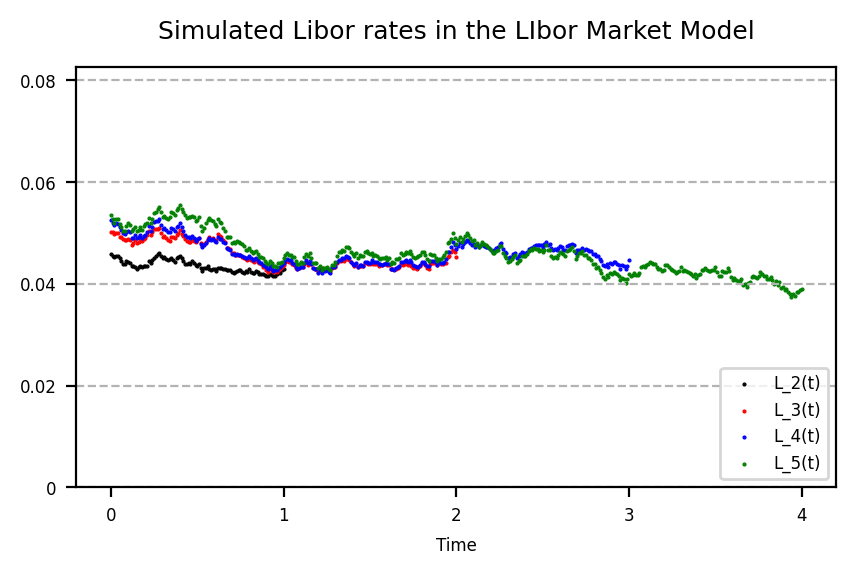

In [ ]:
fig = plt.figure(constrained_layout=False, figsize = (5,3), dpi = 200)
fig.suptitle(f"Simulated Libor rates in the LIbor Market Model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,1,2,3,4])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(t_simul, L_simul[0,:], s = 1, color = 'black', marker = ".",label="L_2(t)")
p2 = ax.scatter(t_simul, L_simul[1,:], s = 1, color = 'red', marker = ".",label="L_3(t)")
p3 = ax.scatter(t_simul, L_simul[2,:], s = 1, color = 'blue', marker = ".",label="L_4(t)")
p4 = ax.scatter(t_simul, L_simul[3,:], s = 1, color = 'green', marker = ".",label="L_5(t)")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

## Swap Market Model (SMM)

### Function: `matrix_swap_to_p`

This function constructs a **matrix** that helps convert **swap rates** into **zero-coupon bond prices** in the **swap market model**.

**Matrix Construction**
The matrix $M$ is constructed such that:
- For the first row:
  $$ M[0, c] = R[0] \cdot \alpha[c], \quad \text{and} \quad M[0, -1] += 1 $$
- For the subsequent rows:
  $$ M[r, r-1] = -1 $$
  $$ M[r, c] = R[r] \cdot \alpha[c], \quad \text{and} \quad M[r, -1] += 1 $$

**Parameters**
- $\alpha$: Lengths of accrual periods for swap payments.
- $R$: Swap rates for each payment period.

In [ ]:
def matrix_swap_to_p(alpha, R):
    """
    Constructs a matrix for converting swap rates to zero-coupon bond prices.

    Parameters:
    alpha : array-like
        Lengths of accrual periods for each swap payment.
    R : array-like
        Swap rates for each payment period.

    Returns:
    ndarray
        Matrix M that can be used for converting swap rates to zero-coupon bond prices.
    """
    N = len(R)
    M = np.zeros([N, N])
    for c in range(N):
        M[0, c] = R[0] * alpha[c]
    M[0, -1] += 1
    for r in range(1, N):
        M[r, r - 1] = -1
        for c in range(r, N):
            M[r, c] = R[r] * alpha[c]
        M[r, -1] += 1
    return M


**Example Usage**

In [ ]:
# Inputs
alpha = np.array([0.25, 0.25, 0.25])  # Accrual periods
R = np.array([0.03, 0.032, 0.033])  # Swap rates

# Call function
M = matrix_swap_to_p(alpha, R)
print(f"Matrix M:\n{M}")

Matrix M:
[[ 0.0075   0.0075   1.0075 ]
 [-1.       0.008    1.008  ]
 [ 0.      -1.       1.00825]]


### Function: `drift_smm`

This function calculates the **drift terms** for the forward swap rates under the **Swap Market Model (SMM)**.

**Formula**
The drift term for the forward swap rate is calculated using:
$$
\text{drift}_n = - \sigma_n \cdot \phi_n
$$
Where:
- $\phi_n$ is the adjustment factor accounting for the zero-coupon bond prices and volatilities.
- $S_n$ is the cumulative sum of zero-coupon bond prices for swaps:
  $$ S_n = \sum_{j=0}^{N+1-n} \alpha_j p_j $$
- $p$: Zero-coupon bond prices, solved using the matrix:
  $$ X \cdot p = y $$

**Parameters**
- $R$: Forward swap rates.
- $\sigma$: Volatility matrix for the forward swap rates.
- $\alpha$: Lengths of accrual periods for each swap payment.



In [ ]:
def drift_smm(R, sigma, alpha):
    """
    Calculates the drift terms for the forward swap rates under the Swap Market Model (SMM).

    Parameters:
    R : array-like
        Forward swap rates.
    sigma : ndarray
        Volatility matrix for the forward swap rates. Shape should be (N, N+1).
    alpha : array-like
        Lengths of accrual periods for each swap payment.

    Returns:
    ndarray
        Drift terms for the forward swap rates.
    """
    N = len(R) - 1
    drift = np.zeros(N + 1)

    # Construct the matrix and solve for zero-coupon bond prices
    X = matrix_swap_to_p(alpha, R)
    y = np.zeros(N + 1)
    y[0] = 1
    p = np.linalg.solve(X, y)

    # Compute cumulative sums of zero-coupon bond prices
    S = np.zeros(N + 1)
    for n in range(N + 1):
        for j in range(N + 1 - n):
            S[n] += alpha[j] * p[j]

    # Compute drift terms
    phi = np.zeros([N, N + 1])
    for n in range(N):
        for j in range(N - 1):
            phi[n, :] += S[j + 1] / S[n] * alpha[j + 1] * R[j + 1] * sigma[j + 1, :]
            for k in range(n + 1, j + 1):
                phi[n] *= (1 + alpha[k] * R[k])
        drift[n] = -np.dot(sigma[n, :], phi[n, :])

    return drift


**Example Usage**

In [ ]:
# Inputs
R = np.array([0.03, 0.032, 0.033])  # Forward swap rates
alpha = np.array([0.25, 0.25, 0.25])  # Accrual periods
sigma = np.array([[0.01, 0.0, 0.0],  # Volatility matrix
                  [0.0, 0.012, 0.0],
                  [0.0, 0.0, 0.011]])

# Call function
drift = drift_smm(R, sigma, alpha)
print(f"Drift Terms: {drift}")

Drift Terms: [-0.000e+00 -1.152e-06  0.000e+00]


### Function: `simul_smm`

This function simulates **forward swap rates** under the **Swap Market Model (SMM)** using Monte Carlo methods.

**Swap Market Model Dynamics**

The forward swap rate $R_i(t)$ evolves according to the SDE:
$$
dR_i(t) = \text{drift}_i \cdot R_i(t) \, dt + \sigma_i \cdot R_i(t) \, dW_t
$$
Where:
- $\text{drift}_i$ is computed using the SMM drift formula.
- $\sigma_i$: Volatility of $R_i$.
- $dW_t$: Correlated Brownian motion.

**Parameters**

- `R0`: Initial forward swap rates.
- $T$: Maturities corresponding to the forward swap rates.
- $\sigma$: Volatilities of the forward swap rates.
- $\rho$: Correlation matrix for the forward swap rates.
- $M$: Total number of time steps for the simulation.

**Returns**

A matrix containing the simulated forward swap rates over the time grid.

In [ ]:
def simul_smm(R0, T, sigma, rho, M, type="regular"):
    """
    Simulates forward swap rates under the Swap Market Model (SMM).

    Parameters:
    R0 : array-like
        Initial forward swap rates.
    T : array-like
        Maturities corresponding to the forward swap rates.
    sigma : array-like
        Volatilities of the forward swap rates.
    rho : ndarray
        Correlation matrix for the forward swap rates.
    M : int
        Total number of simulation time steps.
    type : str, optional
        Type of simulation (default is "regular").

    Returns:
    ndarray
        Simulated forward swap rates over the time grid.
    """
    N = len(R0) - 1
    delta = T[1] * (N + 1) / M
    delta_sqrt = np.sqrt(delta)
    alpha = np.zeros(N + 1)
    for n in range(1, N + 2):
        alpha[n - 1] = T[n] - T[n - 1]
    rho_sqrt = np.real(sqrtm(rho))
    sigma = np.matmul(np.diag(sigma), rho_sqrt)
    R_simul = np.nan * np.ones([N + 1, M + 1])
    R_simul[:, 0] = R0
    stage = 0
    Mps = int(M / (N + 1))
    
    while stage < N + 1:
        Z = np.random.standard_normal([N + 1 - stage, Mps])
        rho_sqrt = np.real(sqrtm(rho[stage:, stage:]))
        for m in range(1, Mps + 1):
            t = delta * (stage * Mps + m - 1)
            alpha[stage] = T[stage + 1] - t
            drift = drift_smm(
                R_simul[stage:, stage * Mps],
                sigma[stage:, stage:],
                alpha[stage:]
            )
            R_simul[stage:, stage * Mps + m] = (
                R_simul[stage:, stage * Mps + m - 1]
                + drift * R_simul[stage:, stage * Mps + m - 1] * delta
                + delta_sqrt * R_simul[stage:, stage * Mps + m - 1]
                * np.matmul(sigma[stage:, stage:], Z[:, m - 1])
            )
        stage += 1

    return R_simul

**Example Usage**

In [157]:
R = np.array([0.03544326, 0.04117089, 0.04464488, 0.04675195, 0.04802996])
sigma_swaption = np.array([0.072,0.084,0.102,0.119,0.141])
rho_swap = np.array([[1,0.95,0.9,0.85,0.8],[0.95,1,0.95,0.9,0.85],[0.9,0.95,1,0.95,0.9],[0.85,0.9,0.95,1,0.95],[0.8,0.85,0.9,0.95,1]])

# Problem 1
np.random.seed(2024)
M, alpha = 6, 1
T = np.array([m*alpha for m in range(0,M)])
p = np.ones(M)
alpha = np.zeros(M)
sigma_lmm = np.ones(M)
for i in range(1,M):
    p[i] = np.exp(-R[i-1]*T[i])
    alpha[i] = T[i]-T[i-1]
R_swap = np.zeros(M-1)
for i in range(0,M-1):
    R_swap[i], af = fid.swap_rate_from_zcb_prices(0,T[i],T[-1],"annual",T,p)

M_simul = 250
t_simul = np.array([i*T[-1]/M_simul for i in range(0,M_simul+1)])
R_simul = simul_smm(R_swap,T,sigma_swaption,rho_swap,M_simul)

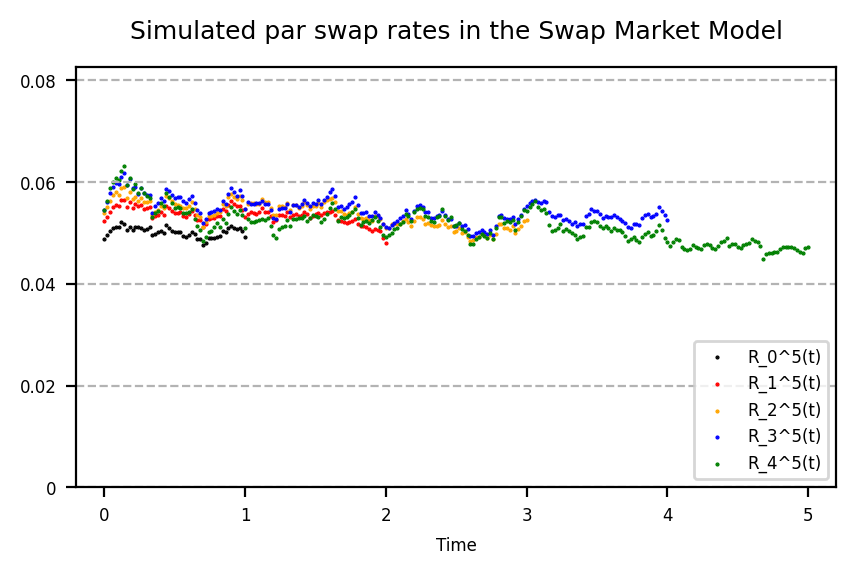

In [ ]:
fig = plt.figure(constrained_layout=False, dpi = 200, figsize = (5,3))
fig.suptitle(f"Simulated par swap rates in the Swap Market Model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,1,2,3,4,5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(t_simul, R_simul[0,:], s = 1, color = 'black', marker = ".",label="R_0^5(t)")
p2 = ax.scatter(t_simul, R_simul[1,:], s = 1, color = 'red', marker = ".",label="R_1^5(t)")
p3 = ax.scatter(t_simul, R_simul[2,:], s = 1, color = 'orange', marker = ".",label="R_2^5(t)")
p4 = ax.scatter(t_simul, R_simul[3,:], s = 1, color = 'blue', marker = ".",label="R_3^5(t)")
p5 = ax.scatter(t_simul, R_simul[4,:], s = 1, color = 'green', marker = ".",label="R_4^5(t)")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

### Function: `zcb_prices_from_swap_rates_normal_smm`

This function calculates **zero-coupon bond (ZCB) prices** from swap rates under the **normal Swap Market Model (SMM)**.

**Formula**

The zero-coupon bond prices are calculated by solving:
$$
X \cdot p = y
$$
Where:
- $X$: Matrix constructed using `matrix_swap_to_p`.
- $p$: Zero-coupon bond prices.
- $y$: A vector where $y[0] = 1$ and all other entries are $0$.

**Parameters**
- `T`: Maturities corresponding to the swap rates.
- `R_swap`: Swap rates for each payment period.

**Returns**

Zero-coupon bond prices corresponding to the maturities in `T`.

In [ ]:
def zcb_prices_from_swap_rates_normal_smm(T, R_swap):
    """
    Calculates zero-coupon bond (ZCB) prices from swap rates under the normal Swap Market Model (SMM).

    Parameters:
    T : array-like
        Maturities corresponding to the swap rates.
    R_swap : array-like
        Swap rates for each payment period.

    Returns:
    ndarray
        Zero-coupon bond prices corresponding to the maturities in T.
    """
    N = len(R_swap)
    alpha = np.zeros(N)
    p = np.ones(N + 1)

    # Compute accrual periods
    for n in range(1, N + 1):
        alpha[n - 1] = T[n] - T[n - 1]

    # Construct the matrix and solve for ZCB prices
    X = matrix_swap_to_p(alpha, R_swap)
    y = np.zeros(N)
    y[0] = 1
    p = np.linalg.solve(X, y)

    return p


**Example Usage**

In [ ]:
# using inputs calculated in the simulation

# Call function
zcb_prices = zcb_prices_from_swap_rates_normal_smm(t_simul, R_swap)
print(f"Zero-Coupon Bond Prices: {zcb_prices}")

Zero-Coupon Bond Prices: [0.9993116  0.99836216 0.99730774 0.99622176 0.99513548]


## Nelson-Siegel functions

### Functions: `F_ns` and `f_ns`

These functions compute two different forms of the **Nelson-Siegel model** for interest rate curves.

**Nelson-Siegel Dynamics**

1. **Integrated Form (`F_ns`)**:
   Computes the integrated Nelson-Siegel curve:
   $$
   F(T) = f_\infty T + \sum_{k=0}^{K-1} a_k b_k^{-(k+1)} \Gamma(k+1, b_k T)
   $$
   Where $\Gamma(k+1, b_k T)$ is the incomplete gamma function.

2. **Forward Rate Form (`f_ns`)**:
   Computes the forward rate of the Nelson-Siegel curve:
   $$
   f(T) = f_\infty + \sum_{k=0}^{K-1} a_k T^k \exp(-b_k T)
   $$

**Differences Between `F_ns` and `f_ns`**

1. **Purpose**:
   - `F_ns` computes the **integrated form** (e.g., cumulative yield or present value of cash flows).
   - `f_ns` computes the **forward rate**, representing the instantaneous rate at a specific time.

2. **Formula**:
   - `F_ns` uses the **incomplete gamma function** ($\Gamma(k+1, b_k T)$).
   - `f_ns` uses the **direct exponential decay** term with $T^k$.

3. **Output**:
   - `F_ns` produces a value reflecting integration over time.
   - `f_ns` produces the value of the forward rate curve.

---

**Parameters**
- `param`: Tuple containing:
  - $f_\infty$: Asymptotic forward rate.
  - $a$: Coefficients for the exponential terms.
  - $b$: Decay rates for the exponential terms.
- `T`: Time(s) to maturity.

In [ ]:
def F_ns(param, T):
    """
    Computes the Nelson-Siegel integral form of the yield curve.

    Parameters:
    param : tuple
        Contains:
        - f_inf: Asymptotic forward rate.
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
    T : float, int, list, tuple, or ndarray
        Time to maturity.

    Returns:
    float or ndarray
        The integrated form of the Nelson-Siegel curve at time(s) T.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        f_inf, a, b = param
        K = len(a)
        F = f_inf * T + a[0] * np.exp(-b[0] * T)
        for k in range(K):
            F += a[k] * b[k]**(-k-1) * gammainc(k + 1, b[k] * T)
    elif isinstance(T, (tuple, list, np.ndarray)):
        f_inf, a, b = param
        K = len(a)
        M = len(T)
        F = np.zeros(M)
        for m in range(M):
            F[m] = f_inf * T[m]
            for k in range(K):
                F[m] += a[k] * b[k]**(-k-1) * gammainc(k + 1, b[k] * T[m])
    return F


In [170]:
def f_ns(param, T):
    """
    Computes the Nelson-Siegel forward rate.

    Parameters:
    param : tuple
        Contains:
        - f_inf: Asymptotic forward rate.
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
    T : float, int, list, tuple, or ndarray
        Time to maturity.

    Returns:
    float or ndarray
        The forward rate of the Nelson-Siegel curve at time(s) T.
    """
    if isinstance(T, (int, float, np.int32, np.int64, np.float64)):
        f_inf, a, b = param
        K = len(a)
        f = f_inf
        for k in range(K):
            f += a[k] * T**k * np.exp(-b[k] * T)
    elif isinstance(T, (tuple, list, np.ndarray)):
        f_inf, a, b = param
        K = len(a)
        M = len(T)
        f = np.zeros(M)
        for m in range(M):
            f[m] = f_inf
            for k in range(K):
                f[m] += a[k] * T[m]**k * np.exp(-b[k] * T[m])
    return f

**Example Usage**

In [ ]:
# Parameters
param = (0.02, [0.03, 0.02], [0.1, 0.2])
T = np.array([1, 2, 3])

# Call functions
F = F_ns(param, T)
f = f_ns(param, T)

print(f"Integrated Nelson-Siegel (F_ns): {F}")
print(f"Forward Rate Nelson-Siegel (f_ns): {f}")

Integrated Nelson-Siegel (F_ns): [0.05731032 0.12515674 0.19870522]
Forward Rate Nelson-Siegel (f_ns): [0.06351974 0.07137472 0.07515324]


### Function: `f_ns_jac`

This function calculates the **Jacobian** of the Nelson-Siegel forward rate model with respect to its parameters.

**Formula**
The forward rate in the Nelson-Siegel model is:
$$
f(T) = f_\infty + \sum_{n=0}^{N} a_n T^n \exp(-b_n T)
$$

The Jacobian is calculated as:
- With respect to $f_\infty$:
  $$ \frac{\partial f(T)}{\partial f_\infty} = 1 $$
- With respect to $a_n$:
  $$ \frac{\partial f(T)}{\partial a_n} = T^n \exp(-b_n T) $$
- With respect to $b_n$:
  $$ \frac{\partial f(T)}{\partial b_n} = -a_n T^{n+1} \exp(-b_n T) $$

**Parameters**
- `param`: Tuple containing:
  - $f_\infty$: Asymptotic forward rate.
  - $a$: Coefficients for the exponential terms.
  - $b$: Decay rates for the exponential terms.
- `T`: Time(s) to maturity.

**Returns**
The function returns a **Jacobian vector** of size `2*(N+1)+1`, where `N` is the number of exponential terms minus 1.


In [ ]:
import numpy as np

def f_ns_jac(param, T):
    """
    Calculates the Jacobian of the Nelson-Siegel forward rate with respect to the parameters.

    Parameters:
    param : tuple
        Contains:
        - f_inf: Asymptotic forward rate.
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
    T : float or ndarray
        Time to maturity.

    Returns:
    ndarray
        Jacobian vector of size `2*(N+1)+1`, where `N` is the length of the array `a` minus 1.
    """
    f_inf, a, b = param
    N = len(a) - 1
    jac = np.zeros(2 * (N + 1) + 1)

    # Partial derivative with respect to f_inf
    jac[0] = 1

    # Partial derivatives with respect to a and b
    for n in range(N + 1):
        jac[1 + n] = T**n * np.exp(-b[n] * T)  # Derivative with respect to a[n]
        jac[1 + N + 1 + n] = -a[n] * T**(n + 1) * np.exp(-b[n] * T)  # Derivative with respect to b[n]

    return jac


**Example Usage**

In [ ]:
# Parameters
param = (0.02, [0.03, 0.02], [0.1, 0.2])
T = 2  # Time to maturity

# Call function
jacobian = f_ns_jac(param, T)
print(f"Jacobian: {jacobian}")

Jacobian: [ 1.          0.81873075  1.34064009 -0.04912385 -0.0536256 ]


### Function: `f_ns_hess`

This function calculates the **Hessian matrix** of the Nelson-Siegel forward rate model with respect to its parameters.

**Formula**
The Hessian contains second derivatives of the forward rate:
1. **Cross derivative with respect to $a_n$ and $b_n$**:
   $$ \frac{\partial^2 f(T)}{\partial a_n \partial b_n} = -T^{n+1} \exp(-b_n T) $$
2. **Second derivative with respect to $b_n$**:
   $$ \frac{\partial^2 f(T)}{\partial b_n^2} = a_n T^{n+2} \exp(-b_n T) $$

**Parameters**
- `param`: Tuple containing:
  - $f_\infty$: Asymptotic forward rate.
  - $a$: Coefficients for the exponential terms.
  - $b$: Decay rates for the exponential terms.
- `T`: Time to maturity.

**Returns**

The function returns a **Hessian matrix** of size `(2*(N+1)+1, 2*(N+1)+1)`, where `N` is the number of exponential terms minus 1.

In [ ]:
import numpy as np

def f_ns_hess(param, T):
    """
    Calculates the Hessian matrix of the Nelson-Siegel forward rate with respect to the parameters.

    Parameters:
    param : tuple
        Contains:
        - f_inf: Asymptotic forward rate.
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
    T : float
        Time to maturity.

    Returns:
    ndarray
        Hessian matrix of size `(2*(N+1)+1, 2*(N+1)+1)`, where `N` is the length of `a` minus 1.
    """
    f_inf, a, b = param
    N = len(a) - 1
    hess = np.zeros([2 * (N + 1) + 1, 2 * (N + 1) + 1])

    # Fill the Hessian matrix
    for n in range(N + 1):
        hess[1 + n, 1 + N + 1 + n] = -T**(n + 1) * np.exp(-b[n] * T)  # (a_n, b_n) cross derivative
        hess[1 + N + 1 + n, 1 + n] = -T**(n + 1) * np.exp(-b[n] * T)  # (b_n, a_n) cross derivative
        hess[1 + N + 1 + n, 1 + N + 1 + n] = a[n] * T**(n + 2) * np.exp(-b[n] * T)  # Second derivative wrt b_n

    return hess


**Example Usage**

In [ ]:
# Parameters
param = (0.02, [0.03, 0.02], [0.1, 0.2])
T = 2  # Time to maturity

# Call function
hessian = f_ns_hess(param, T)
print(f"Hessian Matrix:\n{hessian}")

Hessian Matrix:
[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.         -1.63746151  0.        ]
 [ 0.          0.          0.          0.         -2.68128018]
 [ 0.         -1.63746151  0.          0.09824769  0.        ]
 [ 0.          0.         -2.68128018  0.          0.10725121]]


### Function: `f_ns_T`

This function calculates the **time derivative** of the Nelson-Siegel forward rate curve.

**Formula**

The time derivative of the Nelson-Siegel forward rate curve is:
$$
f_T(T) = -a_0 b_0 \exp(-b_0 T) + \sum_{n=1}^{N-1} \left(a_n n T^{n-1} \exp(-b_n T) - a_n b_n T^n \exp(-b_n T)\right)
$$

**Parameters**
- `param`: Tuple containing:
  - $a$: Coefficients for the exponential terms.
  - $b$: Decay rates for the exponential terms.
- `T`: Time(s) to maturity.

**Returns**

The function returns the **time derivative** of the forward rate curve at the given time(s) $T$.

In [ ]:
import numpy as np

def f_ns_T(param, T):
    """
    Calculates the derivative of the Nelson-Siegel forward rate curve with respect to time.

    Parameters:
    param : tuple
        Contains:
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
    T : float, int, list, tuple, or ndarray
        Time to maturity.

    Returns:
    float or ndarray
        The time derivative of the Nelson-Siegel forward rate curve at time(s) T.
    """
    if isinstance(T, (int, float, np.float32, np.float64)):
        a, b = param
        N = len(a)
        f_T = -a[0] * b[0] * np.exp(-b[0] * T)
        for n in range(1, N):
            f_T += (
                a[n] * n * T**(n - 1) * np.exp(-b[n] * T)
                - a[n] * b[n] * T**n * np.exp(-b[n] * T)
            )
    elif isinstance(T, (tuple, list, np.ndarray)):
        a, b = param
        N = len(a)
        M = len(T)
        f_T = np.zeros(M)
        for m in range(M):
            f_T[m] = -a[0] * b[0] * np.exp(-b[0] * T[m])
            for n in range(1, N):
                f_T[m] += (
                    a[n] * n * T[m]**(n - 1) * np.exp(-b[n] * T[m])
                    - a[n] * b[n] * T[m]**n * np.exp(-b[n] * T[m])
                )
    return f_T


**Example Usage**

In [ ]:
# Parameters
param = ([0.03, 0.02], [0.1, 0.2])  # Coefficients and decay rates
T = np.array([1, 2, 3])  # Time to maturity

# Call function
f_T = f_ns_T(param, T)
print(f"Time Derivative of Forward Rate Curve: {f_T}")

Time Derivative of Forward Rate Curve: [0.01038518 0.00558765 0.00216804]


### Function: `theta_ns`

This function calculates the **drift term (theta)** for the **Nelson-Siegel model** with volatility.

**Formula**

The drift term (theta) in the Nelson-Siegel model is calculated as:
$$
\theta(t) = -a_0 b_0 \exp(-b_0 t) + \sigma^2 t + \sum_{k=1}^{K-1} \left( a_k k t^{k-1} \exp(-b_k t) - a_k b_k t^k \exp(-b_k t) \right)
$$

**Parameters**
- `param`: Tuple containing:
  - $f_\infty$: Asymptotic forward rate.
  - $a$: Coefficients for the exponential terms.
  - $b$: Decay rates for the exponential terms.
  - $\sigma$: Volatility of the short rate.
- `t`: Time(s) to maturity.

**Returns**

The drift term (theta) at the given time(s) `t`.

In [ ]:
def theta_ns(param, t):
    """
    Calculates the drift term (theta) for the Nelson-Siegel model with volatility.

    Parameters:
    param : tuple
        Contains:
        - f_inf: Asymptotic forward rate.
        - a: Array of coefficients for the exponential terms.
        - b: Array of decay rates for the exponential terms.
        - sigma: Volatility of the short rate.
    t : float, int, list, tuple, or ndarray
        Time to maturity.

    Returns:
    float or ndarray
        The drift term (theta) at time(s) t.
    """
    if isinstance(t, (int, float, np.float32, np.float64)):
        f_inf, a, b, sigma = param
        K = len(a)
        theta = -a[0] * b[0] * np.exp(-b[0] * t) + sigma**2 * t
        for k in range(1, K):
            theta += (
                a[k] * k * t**(k - 1) * np.exp(-b[k] * t)
                - a[k] * b[k] * t**k * np.exp(-b[k] * t)
            )
    elif isinstance(t, (tuple, list, np.ndarray)):
        f_inf, a, b, sigma = param
        K = len(a)
        M = len(t)
        theta = np.zeros(M)
        for m in range(M):
            theta[m] = -a[0] * b[0] * np.exp(-b[0] * t[m]) + sigma**2 * t[m]
            for k in range(1, K):
                theta[m] += (
                    a[k] * k * t[m]**(k - 1) * np.exp(-b[k] * t[m])
                    - a[k] * b[k] * t[m]**k * np.exp(-b[k] * t[m])
                )
    return theta


**Example Usage**

In [ ]:
# Parameters
param = (0.02, [0.03, 0.02], [0.1, 0.2], 0.01)  # f_inf, a, b, sigma
t = np.array([1, 2, 3])  # Time to maturity

# Call function
theta = theta_ns(param, t)
print(f"Theta: {theta}")

Theta: [0.01048518 0.00578765 0.00246804]


### Function: `black_caplet_price`

This function calculates the price of a **caplet** using the **Black model**.

**Formula**
The price of a caplet is given by:
1. **Call Option**:
   $$
   \text{Price} = \alpha \cdot p \cdot \left( L \cdot N(d_1) - R \cdot N(d_2) \right)
   $$
2. **Put Option**:
   $$
   \text{Price} = \alpha \cdot p \cdot \left( R \cdot N(-d_2) - L \cdot N(-d_1) \right)
   $$

Where:
- $d_1 = \frac{\ln(L / R) + 0.5 \sigma^2 T}{\sigma \sqrt{T}}$
- $d_2 = \frac{\ln(L / R) - 0.5 \sigma^2 T}{\sigma \sqrt{T}}$
- $N(\cdot)$: Cumulative standard normal distribution.
- $L$: Forward rate.
- $R$: Strike rate.
- $\alpha$: Accrual factor.
- $p$: Discount factor.
- $\sigma$: Volatility of the forward rate.
- $T$: Time to maturity.

**Parameters**
- `sigma`: Volatility of the forward rate.
- `T`: Time to maturity.
- `R`: Strike rate.
- `alpha`: Accrual factor (e.g., day count fraction).
- `p`: Discount factor.
- `L`: Forward rate.
- `type`: Type of the option ("call" or "put").

**Returns**

The function returns the **price of the caplet**.


In [ ]:
def black_caplet_price(sigma, T, R, alpha, p, L, type="call"):
    """
    Calculates the price of a caplet using the Black model.

    Parameters:
    sigma : float
        Volatility of the forward rate.
    T : float
        Time to maturity of the caplet.
    R : float
        Strike rate of the caplet.
    alpha : float
        Accrual factor for the caplet (e.g., day count fraction).
    p : float
        Discount factor for the caplet.
    L : float
        Forward rate.
    type : str, optional
        Type of the caplet option: "call" (default) or "put".

    Returns:
    float
        Price of the caplet.
    """
    d1 = (np.log(L / R) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = (np.log(L / R) - 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    if type == "put":
        price = alpha * p * (R * norm.cdf(-d2) - L * norm.cdf(-d1))
    else:
        price = alpha * p * (L * norm.cdf(d1) - R * norm.cdf(d2))
    return price


**Example Usage**

In [187]:
# Inputs
sigma = 0.02  # Volatility
T = 1  # Time to maturity
R = 0.03  # Strike rate
alpha = 0.25  # Accrual factor
p = 0.97  # Discount factor
L = 0.032  # Forward rate
type_option = "call"  # Option type

# Call function
caplet_price = black_caplet_price(sigma, T, R, alpha, p, L, type=type_option)
print(f"Caplet Price: {caplet_price}")

Caplet Price: 0.0004850251821541764


In [105]:
def black_caplet_delta(sigma,T,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == "call":
        # p_prev = p*(1+alpha*L)
        price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
        delta = alpha*p*ndtr(d1) - alpha/(1+alpha*L)*price
    return delta


In [106]:
def black_caplet_gamma(sigma,T,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == "call":
        gamma = alpha*p*(norm.pdf(d1)/(L*sigma*np.sqrt(T))-2*alpha/((1+alpha*L)**2)*(alpha*R*ndtr(d2) + ndtr(d1)))
    return gamma


In [107]:
def black_caplet_vega(sigma,T,R,alpha,p,L,type = "call"):
    if type == "call":
        d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
        vega = alpha*p*L*norm.pdf(d1) * np.sqrt(T)
    return vega


In [108]:
def black_caplet_theta(sigma,T,r,R,alpha,p,L,type = "call"):
    d1 = (np.log(L/R) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(L/R) - 0.5*sigma**2*(T-alpha))/(sigma*np.sqrt(T-alpha))
    price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
    if type == "call":
        # p_prev = p*(1+alpha*L)
        price = alpha*p*(L*ndtr(d1) - R*ndtr(d2))
        theta = r*price - alpha*p*(sigma*L*norm.pdf(d1))/(2*np.sqrt(T))
    return theta

In [109]:
def black_caplet_iv(C,T,R,alpha,p,L, iv0 = 0.2, max_iter = 200, prec = 1.0e-5):
    iv = iv0
    for i in range(0,max_iter):
        price = black_caplet_price(iv,T,R,alpha,p,L,type = "call")
        vega = black_caplet_vega(iv,T,R,alpha,p,L,type = "call")
        diff = C - price
        if abs(diff) < prec:
            return iv
        iv += diff/vega
    return iv

In [110]:
# Swatiopns
def black_swaption_price(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'put':
        price = S*(K*ndtr(-d2) - R*ndtr(-d1))
    else:
        price = S*(R*ndtr(d1) - K*ndtr(d2))
    return price

In [111]:
def black_swaption_delta(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    # d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        # price = S*(R*ndtr(d1) - K*ndtr(d2))
        delta = S*ndtr(d1)  # - price/R + S*(R*norm.pdf(d1) - K*norm.pdf(d2))/(R*sigma*np.sqrt(T))
    return delta

In [112]:
def black_swaption_gamma(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        price = S*(R*ndtr(d1) - K*ndtr(d2))
        gamma = (2/R**2)*price + (S/R)*(norm.pdf(d1)/(sigma*np.sqrt(T)) - 2*ndtr(d1))
    return gamma

In [113]:
def black_swaption_vega(sigma,T,K,S,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        vega = S*R*norm.pdf(d1) * np.sqrt(T)
    return vega

In [114]:
def black_swaption_theta(sigma,T,K,S,r,R,type = "call"):
    d1 = (np.log(R/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = (np.log(R/K) - 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    if type == 'call':
        price = S*(R*ndtr(d1) - K*ndtr(d2))
        theta = r*price - S*R*sigma*norm.pdf(d1)/(2*np.sqrt(T))
    return theta

In [115]:
def black_swaption_iv(C,T,K,S,R,type = "call", iv0 = 0.2, max_iter = 1000, prec = 1.0e-10):
    iv = iv0
    for i in range(0,max_iter):
        price = black_swaption_price(iv,T,K,S,R,type = "call")
        vega = black_swaption_vega(iv,T,K,S,R,type = "call")
        diff = C - price
        if abs(diff) < prec:
            return iv
        iv += diff/vega
    return iv

In [116]:
# SABR model
def sigma_sabr(K,T,F_0,sigma_0,beta,upsilon,rho,type = "call"):
    if abs(F_0-K) < 1e-8:    # SABR ATM formula
        sigma = sigma_0*F_0**(beta-1)*(1+(((1-beta)**2/24)*(sigma_0**2*(F_0)**(2*beta-2)) + (rho*beta*upsilon*sigma_0/4)*(F_0)**(beta-1) + (2-3*rho**2)/24*upsilon**2)*T)
    else:
        z = (upsilon/sigma_0)*(F_0*K)**((1-beta)/2)*np.log(F_0/K)
        x = np.log((np.sqrt(1-2*rho*z+z**2) + z - rho)/(1-rho))
        D = (F_0*K)**((1-beta)/(2))*(1 + ((1-beta)**2/24)*np.log2(F_0/K) + ((1-beta)**4/1920)*np.emath.logn(4,F_0/K))
        A = 1 + (((1-beta)**2/24)*sigma_0**2*(F_0*K)**(beta-1) + (rho*beta*upsilon*sigma_0/4)*(F_0*K)**((beta-1)/2) + ((2-3*rho**2)/24)*upsilon**2)*T
        sigma = (sigma_0/D)*(z/x)*A
    return sigma

In [117]:
def sabr_simul(F_0,sigma_0,beta,upsilon,rho,M,T):
    sigma, F = np.zeros([M+1]), np.zeros([M+1])
    sigma[0], F[0] = sigma_0, F_0
    delta = T/M
    Z = np.random.standard_normal([2,M])
    delta_sqrt = np.sqrt(delta)
    rho_sqrt = np.sqrt(1-rho**2)
    for m in range(1,M+1):
        F[m] = F[m-1] + sigma[m-1]*F[m-1]**beta*delta_sqrt*Z[0,m-1]
        sigma[m] = sigma[m-1] + upsilon*sigma[m-1]*delta_sqrt*(rho*Z[0,m-1] + rho_sqrt*Z[1,m-1])
    return F, sigma

In [118]:
def fit_sabr_obj(param,sigma_market,K,T,R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    sse = 0
    for n in range(0,N):
        sigma_model = sigma_sabr(K[n],T,R,sigma_0,beta,upsilon,rho,type = "call")
        sse += (sigma_market[n]-sigma_model)**2
    return sse

In [119]:
# Statistics
def data_into_bins(data,N_bins,bin_min = "default",bin_max = "default"):
    # Divide the data in a one-simensional np.array into N_bins bins of equal size.
    N = len(data)
    data = np.sort(data,kind = "stable")
    if bin_min == "default":
        bin_min = data[0]
    if bin_max == "default":
        bin_max = data[-1]
    limits_bins = np.array([bin_min + i*(bin_max-bin_min)/N_bins for i in range(0,N_bins+1)])
    freq = np.zeros([N_bins])
    data_bins = []
    i, j = 0, 0
    while i < N_bins:
        freq_temp = 0
        data_temp = []
        while data[j] <= limits_bins[i+1]:
            data_temp.append(data[j])
            freq_temp += 1
            if j < N - 1:
                j += 1
            elif j == N - 1:
                break
        data_bins.append(np.array(data_temp))
        freq[i] = freq_temp
        i += 1
    return np.array(data_bins), limits_bins, freq

In [120]:
def value_in_list_returns_I_idx(value,list,precision = 1e-12):
    output = False, None
    for i, item in enumerate(list):
        if abs(value-item) < precision:
            output = True, i
            break
    return output

In [121]:
def idx_before_after_in_iterable(value,list):
    idx_before, idx_after = None, None
    if value < list[0]:
        idx_before, idx_after = None, 0
    elif list[-1] < value:
        idx_before, idx_after = len(list) - 1, None
    else:
        for i in range(0,len(list)):
            if list[i] < value:
                idx_before = i
            elif list[i] > value:
                idx_after = i
                break
    return idx_before, idx_after

In [122]:
def value_in_list_of_dict_returns_I_idx(value,L,name,precision = 1e-12):
    output = False, None
    for item in L:
        if abs(value-item[name]) < precision:
            output = True, item
            break
    return output

In [123]:
def nelson_siegel_coef_obj(b,alpha,x1,x2):
    se = (alpha-(1-np.exp(-b*x2))/(1-np.exp(-b*x1)))**2
    return se

In [124]:
def nelson_siegel_coef(x1,x2,y0,y1,y2):
    alpha = (y0-y2)/(y0-y1)
    b_hat = 2*(alpha*x1-x2)/(alpha*x1**2-x2**2)
    result = minimize(nelson_siegel_coef_obj,b_hat,method = "nelder-mead",args = (alpha,x1,x2),options={'xatol': 1e-12,"disp": False})
    if type(result.x) == np.ndarray:
        b = result.x[0]
    elif type(result.x) == int or type(result.x) == int or type(result.x) == np.int32 or type(result.x) == np.int64 or type(result.x) == np.float64:
        b = result.x
    a = (y0-y1)/(1-np.exp(-b*x1))
    f_inf = y0 - a
    return f_inf, a, b

In [125]:
def R_T_endo_from_R_T_fra(R_fra,T_fra,T_endo,fra_data):
    R_fra.reverse(), T_fra.reverse()
    R_endo = [None]*len(T_endo)
    for i in range(0,len(T_fra)):
        I_fra, dict_fra = value_in_list_of_dict_returns_I_idx(T_fra[i],fra_data,"maturity")
        if I_fra is True:
            idx_endo = fid.value_in_list_returns_I_idx(dict_fra["exercise"],T_endo)[1]
            R_endo[idx_endo] = (R_fra[i]*T_fra[i] - np.log(1+(dict_fra["maturity"]-dict_fra["exercise"])*dict_fra["rate"]))/T_endo[idx_endo]
    R_fra.reverse(), T_fra.reverse()
    R_endo.reverse(), T_endo.reverse()
    for i in range(0,len(T_endo)):
        I_fra, dict_fra = value_in_list_of_dict_returns_I_idx(T_endo[i],fra_data,"maturity")
        if I_fra is True:
            idx_endo = fid.value_in_list_returns_I_idx(dict_fra["exercise"],T_endo)[1]
            R_endo[idx_endo] = (R_endo[i]*T_endo[i] - np.log(1+(dict_fra["maturity"]-dict_fra["exercise"])*dict_fra["rate"]))/T_endo[idx_endo]
    R_endo.reverse(), T_endo.reverse()
    return R_endo

In [126]:
def extrapolate(x_extra,x,y,extrapolation_options = {"method":"linear"}):
    # Extrapoltion of value corresponding to a choice of x_extra
    if extrapolation_options["method"] == "linear":
        if x_extra < x[0]:
            a = (y[1]-y[0])/(x[1]-x[0])
            b = y[0]-a*x[0]
            y_extra = a*x_extra + b
            y_extra_deriv = a
        elif x[-1] < x_extra:
            a = (y[-1]-y[-2])/(x[-1]-x[-2])
            b = y[-1]-a*x[-1]
            y_extra = a*x_extra + b
            y_extra_deriv = a
        else:
            print(f"WARNING! x_extra is inside the dataset")
    elif extrapolation_options["method"] == "hermite":
        if x_extra < x[0]:
            coefs = hermfit(x[0:extrapolation_options["degree"]+1],y[0:extrapolation_options["degree"]+1],extrapolation_options["degree"])
            y_extra, y_extra_deriv = hermval(x_extra,coefs), hermval(x_extra,hermder(coefs))
        elif x[-1] < x_extra:
            coefs = hermfit(x[-extrapolation_options["degree"]-1:],y[-extrapolation_options["degree"]-1:],extrapolation_options["degree"])
            y_extra, y_extra_deriv = hermval(x_extra,coefs), hermval(x_extra,hermder(coefs))
        else:
            print(f"WARNING! x_extra is inside the dataset")
    elif extrapolation_options["method"] == "nelson_siegel":
        if x_extra < x[0]:
            x1, x2 = x[1]-x[0], x[2]-x[0]
            coefs = nelson_siegel_coef(x1,x2,y[0],y[1],y[2])
            y_extra, y_extra_deriv = coefs[0]+coefs[1]*np.exp(-coefs[2]*(x_extra-x[0])), -coefs[1]*coefs[2]*np.exp(-coefs[2]*(x_extra-x[0]))
        elif x[-1] < x_extra:
            x1, x2 = x[-2]-x[-3], x[-1]-x[-3]
            coefs = nelson_siegel_coef(x1,x2,y[-3],y[-2],y[-1])
            y_extra, y_extra_deriv = coefs[0]+coefs[1]*np.exp(-coefs[2]*(x_extra-x[-3])), -coefs[1]*coefs[2]*np.exp(-coefs[2]*(x_extra-x[-3]))
        else:
            print(f"WARNING! x_extra is inside the dataset")
    return y_extra, y_extra_deriv


In [127]:
def interpolate(x_inter,x,y,interpolation_options = {"method":"linear", "transition": None}):
    N, M = len(x_inter), len(x)
    y_inter, y_inter_deriv = np.nan*np.ones([N]), np.nan*np.ones([N])
    if interpolation_options["method"] == "linear":
        coefs = np.nan*np.ones([M,2])
        for m in range(0,M-1):
            coefs[m,1] = (y[m+1]-y[m])/(x[m+1]-x[m])
            coefs[m,0] = y[m]-coefs[m,1]*x[m]
        coefs[M-1,1] = (y[M-1] - y[M-2])/(x[M-1]-x[M-2])
        coefs[M-1,0] = y[M-1] - coefs[M-1,1]*x[M-1]
        for n in range(0,N):
            if x_inter[n] < x[0] or x_inter[n] > x[M-1]:
                extrapolate(x_inter[n],x,y,extrapolation_options = interpolation_options)
            else:
                I_known, idx = fid.value_in_list_returns_I_idx(x_inter[n],x)
                if I_known is True:
                    y_inter[n] = y[idx]
                    if idx == 0:
                        y_inter_deriv[n] = coefs[0,1]
                    elif idx == M-1:
                        y_inter_deriv[n] = coefs[M-1,1]
                    else:
                        y_inter_deriv[n] = 0.5*coefs[idx-1,1] + 0.5*coefs[idx,1]
                        y_inter_deriv[n] = coefs[idx,1]
                else:
                    idx_before, idx_after = idx_before_after_in_iterable(x_inter[n],x)
                    if interpolation_options["transition"] == "smooth":
                        w_before = (x[idx_after]-x_inter[n])/(x[idx_after]-x[idx_before])
                        y_before, y_after = coefs[idx_before,0] + coefs[idx_before,1]*x_inter[n], coefs[idx_after,0] + coefs[idx_after,1]*x_inter[n]

                        y_inter[n] = w_before*y_before + (1-w_before)*y_after
                        y_inter_deriv[n] = w_before*coefs[idx_before,1] + (1-w_before)*coefs[idx_after,1]
                    else:
                        y_inter[n] = coefs[idx_before,0] + coefs[idx_before,1]*x_inter[n]
                        y_inter_deriv[n] = coefs[idx_before,1]
    elif interpolation_options["method"] == "hermite":
        coefs = np.nan*np.ones([M,interpolation_options["degree"]+1])
        degrees = np.ones(M, dtype = "int")
        for m in range(0, M-1):
            left = min(int(interpolation_options["degree"]/2),m)
            right = min(M-1-m,int((interpolation_options["degree"]+1)/2))
            degrees[m] = left + right
            coefs[m,0:left+right+1] = hermfit(x[m-left:m+right+1],y[m-left:m+right+1],degrees[m])
        coefs[M-1], degrees[M-1] = coefs[M-2], degrees[M-2]
        for n in range(0,N):
            if x_inter[n] < x[0] or x_inter[n] > x[M-1]:
                y_inter[n], y_inter_deriv[n] = extrapolate(x_inter[n],x,y,extrapolation_options = interpolation_options)
            else:
                I_known, idx = fid.value_in_list_returns_I_idx(x_inter[n],x)
                if I_known is True:
                    y_inter[n] = y[idx]
                    y_inter_deriv[n] = hermval(x_inter[n],hermder(coefs[idx,0:degrees[idx]+1]))
                else:
                    idx_before, idx_after = idx_before_after_in_iterable(x_inter[n],x)
                    if interpolation_options["transition"] == "smooth":
                        w_before = (x[idx_after]-x_inter[n])/(x[idx_after]-x[idx_before])
                        y_before = hermval(x_inter[n],coefs[idx_before,0:degrees[idx_before]+1])
                        y_after = hermval(x_inter[n],coefs[idx_after,0:degrees[idx_after]+1])
                        y_inter[n] = w_before*y_before + (1-w_before)*y_after
                        y_inter_deriv[n] = w_before*hermval(x_inter[n],hermder(coefs[idx_before,0:degrees[idx_before]+1])) + (1-w_before)*hermval(x_inter[n],hermder(coefs[idx_after,0:degrees[idx_after]+1]))
                    else:
                        y_inter[n] = hermval(x_inter[n],coefs[idx_before,0:degrees[idx_before]+1])
                        y_inter_deriv[n] = hermval(x_inter[n],hermder(coefs[idx_before,0:degrees[idx_before]+1]))
    elif interpolation_options["method"] == "nelson_siegel":
        coefs, type_fit = np.nan*np.ones([M,3]), M*[None]
        for m in range(1,M-1):
            if (y[m] > y[m-1] and y[m+1] > y[m]) or (y[m] < y[m-1] and y[m+1] < y[m]):
                coefs[m,0:3] = nelson_siegel_coef(x[m]-x[m-1],x[m+1]-x[m-1],y[m-1],y[m],y[m+1])
                type_fit[m] = "nelson_siegel"
            else:
                coefs[m,0:3] = hermfit(x[m-1:m+2],y[m-1:m+2],2)
                type_fit[m] = "hermite"
        for n in range(0,N):
            if x_inter[n] < x[0] or x_inter[n] > x[M-1]:
                y_inter[n], y_inter_deriv[n] = extrapolate(x_inter[n],x,y,extrapolation_options = interpolation_options)
            else:
                I_known, idx = fid.value_in_list_returns_I_idx(x_inter[n],x)
                if I_known is True:
                    y_inter[n] = y[idx]
                    if idx == 0:
                        if type_fit[idx+1] == "nelson_siegel":
                            x_ns = x_inter[n] - x[idx]
                            y_inter_deriv[n] = -coefs[idx+1,1]*coefs[idx+1,2]*np.exp(-coefs[idx+1,2]*x_ns)
                        elif type_fit[idx+1] == "hermite":
                            y_inter_deriv[n] = hermval(x_inter[n],hermder(coefs[idx+1,0:3]))
                    elif idx == M-1:
                        if type_fit[idx-1] == "nelson_siegel":
                            x_ns = x_inter[n] - x[idx-2]
                            y_inter_deriv[n] = -coefs[idx-1,1]*coefs[idx-1,2]*np.exp(-coefs[idx-1,2]*x_ns)
                        elif type_fit[idx-1] == "hermite":
                            y_inter_deriv[n] = hermval(x_inter[n],hermder(coefs[idx-1,0:3]))
                    else:
                        if type_fit[idx] == "nelson_siegel":
                            x_ns = x_inter[n] - x[idx-1]
                            y_inter_deriv[n] = -coefs[idx,1]*coefs[idx,2]*np.exp(-coefs[idx,2]*x_ns)
                        elif type_fit[idx] == "hermite":
                            y_inter_deriv[n] = hermval(x_inter[n],hermder(coefs[idx,0:3]))
                else:
                    idx_before, idx_after = idx_before_after_in_iterable(x_inter[n],x)
                    if idx_before == 0:
                        if type_fit[idx_before+1] == "nelson_siegel":
                            x_ns = x_inter[n] - x[idx_before]
                            y_inter[n], y_inter_deriv[n] = coefs[idx_after,0] + coefs[idx_after,1]*np.exp(-coefs[idx_after,2]*x_ns), -coefs[idx_after,1]*coefs[idx_after,2]*np.exp(-coefs[idx_after,2]*x_ns)
                            y_inter_deriv[n] = -coefs[idx_after,1]*coefs[idx_after,2]*np.exp(-coefs[idx_after,2]*x_ns)
                        elif type_fit[idx_before+1] == "hermite":
                            y_inter[n], y_inter_deriv[n] = hermval(x_inter[n],coefs[idx_after,0:3]), hermval(x_inter[n],hermder(coefs[idx_after,0:3]))
                    elif idx_after == M-1:
                        if type_fit[idx_after-1] == "nelson_siegel":
                            x_ns = x_inter[n] - x[idx_after-2]
                            y_inter[n], y_inter_deriv[n] = coefs[idx_after-1,0] + coefs[idx_after-1,1]*np.exp(-coefs[idx_after-1,2]*x_ns), -coefs[idx_after-1,1]*coefs[idx_after-1,2]*np.exp(-coefs[idx_after-1,2]*x_ns)
                        elif type_fit[idx_after-1] == "hermite":
                            y_inter[n], y_inter_deriv[n] = hermval(x_inter[n],coefs[idx_after-1,0:3]), hermval(x_inter[n],hermder(coefs[idx_after-1,0:3]))
                    else:
                        if interpolation_options["transition"] == "smooth":
                            w_left = (x[idx_after]-x_inter[n])/(x[idx_after]-x[idx_before])
                            if type_fit[idx_before] == "nelson_siegel":
                                x_left = x_inter[n] - x[idx_before-1]
                                y_left, y_left_deriv = coefs[idx_before,0] + coefs[idx_before,1]*np.exp(-coefs[idx_before,2]*x_left), -coefs[idx_before,1]*coefs[idx_before,2]*np.exp(-coefs[idx_before,2]*x_left)
                            elif type_fit[idx_before] == "hermite":
                                y_left, y_left_deriv = hermval(x_inter[n],coefs[idx_before,0:3]), hermval(x_inter[n],hermder(coefs[idx_before,0:3]))
                            if type_fit[idx_after] == "nelson_siegel":
                                x_right = x_inter[n] - x[idx_after-1]
                                y_right, y_right_deriv = coefs[idx_after,0] + coefs[idx_after,1]*np.exp(-coefs[idx_after,2]*x_right), -coefs[idx_after,1]*coefs[idx_after,2]*np.exp(-coefs[idx_after,2]*x_right)
                            elif type_fit[idx_after] == "hermite":
                                y_right, y_right_deriv = hermval(x_inter[n],coefs[idx_after,0:3]), hermval(x_inter[n],hermder(coefs[idx_after,0:3]))
                            y_inter[n], y_inter_deriv[n] = w_left*y_left + (1-w_left)*y_right, w_left*y_left_deriv + (1-w_left)*y_right_deriv
                        else:
                            if type_fit[idx_before] == "nelson_siegel":
                                x_ns = x_inter[n] - x[idx_before-1]
                                y_inter[n], y_inter_deriv[n] = coefs[idx_before,0] + coefs[idx_before,1]*np.exp(-coefs[idx_before,2]*x_ns), -coefs[idx_before,1]*coefs[idx_before,2]*np.exp(-coefs[idx_before,2]*x_ns)
                            elif type_fit[idx_before] == "hermite":
                                y_inter[n], y_inter_deriv[n] = hermval(x_inter[n],coefs[idx_before,0:3]), hermval(x_inter[n],hermder(coefs[idx_before,0:3]))
    return y_inter, y_inter_deriv


In [128]:
def zcb_curve_fra_fit_obj(R_fra,T_fra,T_known,T_endo,T_all,R_all,fra_data,interpolation_options,scaling = 1):
    sse = 0
    R_fra = list(R_fra)
    R_endo = R_T_endo_from_R_T_fra(R_fra,T_fra,T_endo,fra_data)
    for i in range(0,len(T_fra)):
        if T_fra[i] > min(T_known):
            sse += (R_all[fid.value_in_list_returns_I_idx(T_fra[i],T_all)[1]] - R_fra[i])**2
    for i in range(0,len(T_endo)):
        if T_endo[i] > min(T_known):
            sse += (R_all[fid.value_in_list_returns_I_idx(T_endo[i],T_all)[1]] - R_endo[i])**2
    sse *= scaling
    return sse


In [129]:
# ZCB curvefitting
def zcb_curve_swap_fit_obj(R_knot,T_known,T_knot,T_all,R_known,swap_data,interpolation_options,scaling = 1):
    sse = 0
    R_knot = list(R_knot)
    R_all, R_deriv = interpolate(T_all,T_known + T_knot,R_known + R_knot,interpolation_options)
    p = zcb_prices_from_spot_rates(T_all,R_all)
    for n, swap in enumerate(swap_data):
        if swap["fixed_freq"] == "quarterly":
            alpha = 0.25
        if swap["fixed_freq"] == "semiannual":
            alpha = 0.5
        if swap["fixed_freq"] == "annual":
            alpha = 1
        S_swap = 0
        for idx in swap["indices"]:
            S_swap += alpha*p[idx]
        R_swap = (1 - p[swap["indices"][-1]])/S_swap
        sse += (R_swap - swap["rate"])**2
    sse *= scaling
    return sse

In [130]:
def zcb_curve_interpolate(T_inter,T,R,interpolation_options = {"method":"linear"}):
    N = len(T_inter)
    p_inter = np.ones([N])
    R_inter = np.zeros([N])
    f_inter = np.zeros([N])
    R_inter, R_inter_deriv = interpolate(T_inter,T,R,interpolation_options = interpolation_options)
    for i in range(0,N):
        f_inter[i] = R_inter[i] + R_inter_deriv[i]*T_inter[i]
        p_inter[i] = np.exp(-R_inter[i]*T_inter[i])
    return p_inter, R_inter, f_inter, T_inter


In [131]:
def zcb_curve_fit(data_input,interpolation_options = {"method": "linear"},scaling = 1):
    data = copy.deepcopy(data_input)
    data_known = []
    libor_data, fra_data, swap_data = [], [], []
    # Separateing the data and constructing data_known from fixings
    for item in data:
        if item["instrument"] == "libor":
            libor_data.append(item)
            data_known.append({"maturity":item["maturity"],"rate":np.log(1+item["rate"]*item["maturity"])/item["maturity"]})
        elif item["instrument"] == "fra":
            fra_data.append(item)
        elif item["instrument"] == "swap":
            swap_data.append(item)
    # Adding elements to data_knwon based on FRAs
    I_done = False
    while I_done == False:
        for fra in fra_data:
            I_exer, known_exer = value_in_list_of_dict_returns_I_idx(fra["exercise"],data_known,"maturity")
            I_mat, known_mat = value_in_list_of_dict_returns_I_idx(fra["maturity"],data_known,"maturity")
            if I_exer == True and I_mat == False:
                data_known.append({"maturity":fra["maturity"],"rate":(known_exer["rate"]*known_exer["maturity"]+np.log(1+(fra["maturity"]-fra["exercise"])*fra["rate"]))/fra["maturity"]})
                I_done = False
                break
            if I_exer == False and I_mat == True:
                pass
            if I_exer == True and I_mat == True:
                pass
            else:
                I_done = True
    T_known, T_swap, T_knot = [], [], []
    R_known = []
    # Finding T's and corresponding R's where there is some known data
    for known in data_known:
        T_known.append(known["maturity"])
        R_known.append(known["rate"])
    # Finding T_swap - The times where there is a cashflow to at least one of the swaps.
    for swap in swap_data:
        T_knot.append(swap["maturity"])
        if swap["float_freq"] == "quarterly":
            if fid.value_in_list_returns_I_idx(0.25,T_known)[0] == False and fid.value_in_list_returns_I_idx(0.25,T_swap)[0] == False:
                T_swap.append(0.25)
        elif swap["float_freq"] == "semiannual":
            if fid.value_in_list_returns_I_idx(0.5,T_known)[0] == False and fid.value_in_list_returns_I_idx(0.5,T_swap)[0] == False:
                T_swap.append(0.5)
        elif swap["float_freq"] == "annual":
            if fid.value_in_list_returns_I_idx(1,T_known)[0] == False and fid.value_in_list_returns_I_idx(1,T_swap)[0] == False:
                T_swap.append(1)
        if swap["fixed_freq"] == "quarterly":
            for i in range(1,4*swap["maturity"]):
                if fid.value_in_list_returns_I_idx(i*0.25,T_known)[0] == False and fid.value_in_list_returns_I_idx(i*0.25,T_knot)[0] == False and fid.value_in_list_returns_I_idx(i*0.25,T_swap)[0] == False:
                    T_swap.append(i*0.25)
        elif swap["fixed_freq"] == "semiannual":
            for i in range(1,2*swap["maturity"]):
                if fid.value_in_list_returns_I_idx(i*0.5,T_known)[0] == False and fid.value_in_list_returns_I_idx(i*0.5,T_knot)[0] == False and fid.value_in_list_returns_I_idx(i*0.5,T_swap)[0] == False:
                    T_swap.append(i*0.5)
        elif swap["fixed_freq"] == "annual":
            for i in range(1,swap["maturity"]):
                if fid.value_in_list_returns_I_idx(i,T_known)[0] == False and fid.value_in_list_returns_I_idx(i*1,T_knot)[0] == False and fid.value_in_list_returns_I_idx(i,T_swap)[0] == False:
                    T_swap.append(i)
    # Finding T_fra and T_endo
    T_endo, T_fra = [], []
    fra_data.reverse()
    for fra in fra_data:
        if fid.value_in_list_returns_I_idx(fra["maturity"],T_known)[0] == False:
            I_fra_mat, idx_fra_mat = fid.value_in_list_returns_I_idx(fra["maturity"],T_fra)
            I_endo_mat, idx_endo_mat = fid.value_in_list_returns_I_idx(fra["maturity"],T_endo)
            if I_fra_mat is False and I_endo_mat is False:
                T_fra.append(fra["maturity"])
            elif I_fra_mat is True and I_endo_mat is False:
                pass
            elif I_fra_mat is False and I_endo_mat is True:
                pass
            elif I_fra_mat is True and I_endo_mat is True:
                T_fra.pop(idx_fra_mat)
        if fid.value_in_list_returns_I_idx(fra["exercise"],T_known)[0] == False:
            I_fra_exer, idx_fra_exer = fid.value_in_list_returns_I_idx(fra["exercise"],T_fra)
            I_endo_exer, idx_endo_exer = fid.value_in_list_returns_I_idx(fra["exercise"],T_endo)
            if I_fra_exer is False and I_endo_exer is False:
                T_endo.append(fra["exercise"])
            elif I_fra_exer is True and I_endo_exer is False:
                T_fra.pop(idx_fra_exer)
                T_endo.append(fra["exercise"])
            elif I_fra_exer is False and I_endo_exer is True:
                pass
            elif I_fra_exer is True and I_endo_exer is True:
                T_fra.pop(idx_fra_exer)
    fra_data.reverse()
    # Fitting the swap portion of the curve
    T_swap_fit = T_known + T_swap + T_knot
    T_swap_fit.sort(), T_fra.sort(), T_endo.sort()
    R_knot_init = [None]*len(swap_data)
    for i, swap in enumerate(swap_data):
        indices = []
        if swap["fixed_freq"] == "quarterly":
            for j in range(1,4*swap["maturity"]+1):
                indices.append(fid.value_in_list_returns_I_idx(j*0.25,T_swap_fit)[1])
        elif swap["fixed_freq"] == "semiannual":
            for j in range(1,2*swap["maturity"]+1):
                indices.append(fid.value_in_list_returns_I_idx(j*0.5,T_swap_fit)[1])
        elif swap["fixed_freq"] == "annual":
            for j in range(1,swap["maturity"]+1):
                indices.append(fid.value_in_list_returns_I_idx(j,T_swap_fit)[1])
        swap["indices"] = indices
        R_knot_init[i] = swap["rate"]
        i += 1
    args = (T_known,T_knot,T_swap_fit,R_known,swap_data,interpolation_options,1)
    result = minimize(zcb_curve_swap_fit_obj,R_knot_init,method = 'nelder-mead',args = args,options={'xatol': 1e-6,'disp': False})
    T_swap_curve, R_swap_curve = T_known + T_knot, R_known + list(result.x)
    T_fra_fit = T_swap_curve + T_fra + T_endo
    T_fra_fit.sort()
    R_fra_fit, R_fra_fit_deriv = interpolate(T_fra_fit,T_swap_curve,R_swap_curve,interpolation_options)
    R_fra_init = [None]*len(T_fra)
    for i in range(0,len(T_fra)):
        R_fra_init[i] = R_fra_fit[fid.value_in_list_returns_I_idx(T_fra[i],T_fra_fit)[1]]
    args = (T_fra,T_known,T_endo,T_fra_fit,R_fra_fit,fra_data,interpolation_options,scaling)
    result = minimize(zcb_curve_fra_fit_obj,R_fra_init,method = 'nelder-mead',args = args,options={'xatol': 1e-6,'disp': False})
    R_fra = list(result.x)
    R_endo = R_T_endo_from_R_T_fra(R_fra,T_fra,T_endo,fra_data)
    for i in range(0,len(T_fra_fit)):
        I_fra, idx_fra = fid.value_in_list_returns_I_idx(T_fra_fit[i],T_fra)
        if I_fra is True:
            R_fra_fit[i] = R_fra[idx_fra]
        elif I_fra is False:
            I_endo, idx_endo = fid.value_in_list_returns_I_idx(T_fra_fit[i],T_endo)
            if I_endo is True:
                R_fra_fit[i] = R_endo[idx_endo]
    return np.array(T_fra_fit), np.array(R_fra_fit)


In [132]:
def market_rate_bump(idx_bump,size_bump,T_inter,data,interpolation_options = {"method": "linear"}):
    data_bump = copy.deepcopy(data)
    if type(idx_bump) == int or type(idx_bump) == float or type(idx_bump) == np.float64 or type(idx_bump) == np.int32 or type(idx_bump) == np.int64:
        data_bump[idx_bump]["rate"] += size_bump
        T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
        p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_inter,T_fit_bump,R_fit_bump,interpolation_options = interpolation_options)
    elif type(idx_bump) == tuple or type(idx_bump) == list or type(idx_bump) == np.ndarray:
        if type(size_bump) == int or type(size_bump) == float or type(size_bump) == np.float64 or type(size_bump) == np.int32 or type(size_bump) == np.int64:
            for i in range(0,len(idx_bump)):
                data_bump[idx_bump[i]]["rate"] += size_bump
            T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
            p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_inter,T_fit_bump,R_fit_bump,interpolation_options = interpolation_options)
        elif type(size_bump) == tuple or type(size_bump) == list or type(size_bump) == np.ndarray:
            for i in range(0,len(idx_bump)):
                data_bump[idx_bump[i]]["rate"] += size_bump[i]
            T_fit_bump, R_fit_bump = zcb_curve_fit(data_bump,interpolation_options = interpolation_options)
            p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump = zcb_curve_interpolate(T_inter,T_fit_bump,R_fit_bump,interpolation_options = interpolation_options)
    return p_inter_bump, R_inter_bump, f_inter_bump, T_inter_bump, data_bump

In [133]:
def swap_indices(data,T):
    for item in data:
        if item["instrument"] == "swap":
            indices = []
            if item["fixed_freq"] == "quarterly":
                for i in range(1,4*item["maturity"]+1):
                    indices.append(fid.value_in_list_returns_I_idx(i*0.25,T)[1])
            elif item["fixed_freq"] == "semiannual":
                for i in range(1,2*item["maturity"]+1):
                    indices.append(fid.value_in_list_returns_I_idx(i*0.5,T)[1])
            elif item["fixed_freq"] == "annual":
                for i in range(1,item["maturity"]+1):
                    indices.append(fid.value_in_list_returns_I_idx(i,T)[1])
            item["indices"] = indices
    return data


In [134]:
# Fitting the initial term structure of forward rates (For use in the Ho-Lee and Hull-White extended Vasicek models)
def theta(t,sigma,args):
    if args["model"] == "nelson-siegel":
        a = args["a"]
        b = args["b"]
        if type(t) == int or type(t) == float or type(t) == np.int32 or type(t) == np.int64 or type(t) == np.float64:
            K = len(a)
            theta = -a[0]*b[0]*np.exp(-b[0]*t) + sigma**2*t
            for k in range(1,K):
                theta += a[k]*k*t**(k-1)*np.exp(-b[k]*t) - a[k]*b[k]*t**k*np.exp(-b[k]*t)
        elif type(t) == tuple or type(t) == list or type(t) == np.ndarray:
            K = len(a)
            M = len(t)
            theta = np.zeros([M])
            for m in range(0,M):
                theta[m] = -a[0]*b[0]*np.exp(-b[0]*t[m]) + sigma**2*t[m]
                for k in range(1,K):
                    theta[m] += a[k]*k*t[m]**(k-1)*np.exp(-b[k]*t[m]) - a[k]*b[k]*t[m]**k*np.exp(-b[k]*t[m])
    if args["model"] == "interpolation":
        # Takes a vector theta on some grid T an expands that vector to the grid in t by linear interpolation
        T = args["T"]
        theta_star = args["theta_star"]
        M, N = len(t), len(T)
        theta = np.zeros([M])
        i, j = 0, 0
        while i < M:
            while j < N:
                if t[i] < T[j]:
                    print(f"WARNING! Not able to compute theta for t: {t[i]}. t less than T, t: {t[i]}, T: {T[j]}")
                    i += 1
                elif T[j] <= t[i] <= T[j+1]:
                    w_right = (t[i] - T[j])/(T[j+1]-T[j])
                    theta[i] = w_right*theta_star[j+1] + (1-w_right)*theta_star[j]
                    if i + 1 > M - 1:
                        j = N
                    i += 1
                elif t[i] > T[j+1]:
                    if j + 1 > N - 1:
                        print(f"WARNING! Not able to compute theta for t: {t[i]}. t greater than T, t: {t[i]}, T: {T[j]}")
                    else:
                        j += 1
    return theta
